# FCV Slide Deck
XX.

```{thebe}
```

In [ ]:
# %%
# jupyter: {'source_hidden': true}
import os
import sys
import re
import requests
import socket
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pandas as pd
from typing import List, Dict, Any, Optional, Union
import numpy as np
import geopandas as gpd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Set up project paths
root_dir = Path.cwd().parent  # Assumes the notebook is inside a subfolder
data_dir = root_dir / 'data'
source_dir = data_dir / 'fsi-historic'

# Ensure project root is in the Python path
if str(root_dir) not in sys.path:
    sys.path.append(str(root_dir))

# Import FCV utilities & style guide
from src.utils import (
    UCDP, GIC, ACLEDDataFetcher, RegionMapper, UNHCRDataFinder,
    WorldBankAPI, FSIDataProcessor, FragilityClassifier,
    RefugeeAnalyzer, UNPopulationDataPortalAPI
)

import fcv_style  # Automatically applies FCV styling

# Initialize data processors
ucdp = UCDP()
gic = GIC()
region_mapper = RegionMapper()
unhcr = UNHCRDataFinder()
wb = WorldBankAPI()



FCV Notebook Style Loaded.


# Conflict
## Number of Armed Conflicts by Type
XX.

> ⚠ **Important**  
>  
> **Conflict Type Definitions:**  
> - **Extrasystemic:** Conflicts between a state and a non-state actor outside the state's territory.  
> - **Interstate:** Conflicts between two or more states.  
> - **Internationalized intrastate:** Conflicts occurring within a state but involving external states supporting one or more parties.  
> - **Intrastate:** Conflicts occurring within a single state between government forces and non-state groups.   
>  
> **Definition of Armed Conflict:**  
> Armed conflict refers to a contested incompatibility that concerns government and/or territory, where the use of armed force between two or more organized parties results in at least 25 battle-related deaths in a year.
>
> 📌 More details on conflict definitions can be found at [Uppsala Conflict Data Program (UCDP) Definitions](https://www.uu.se/en/department/peace-and-conflict-research/research/ucdp/ucdp-definitions). 


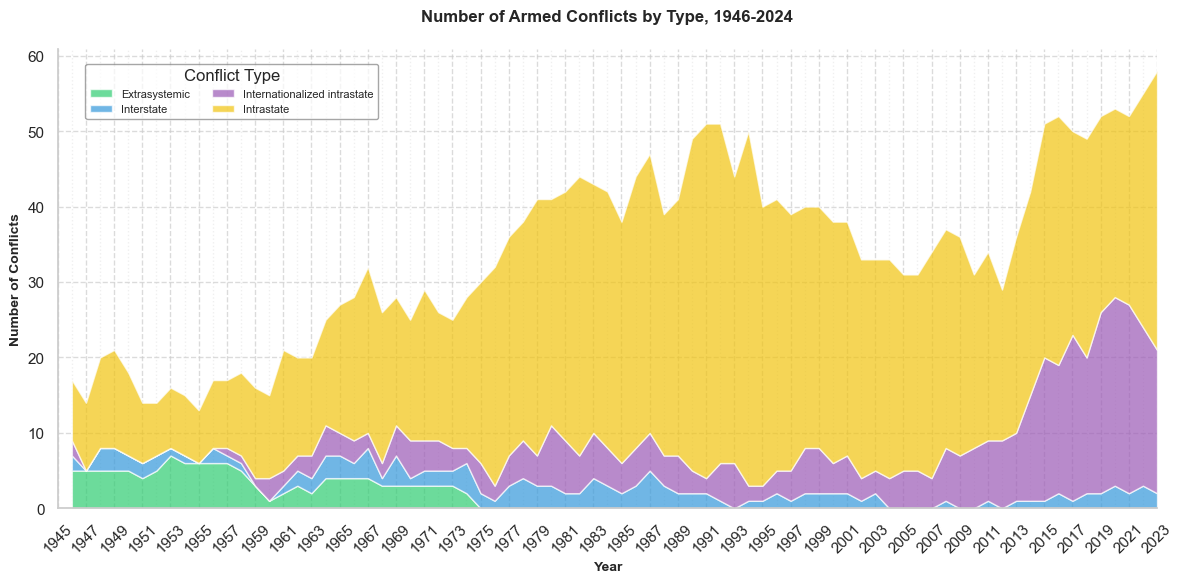

In [2]:
# %%
# jupyter: {'source_hidden': true}
# Fetch UCDP data
raw_data = ucdp.fetch_ucdp_data()
df_conflicts = ucdp.process_conflict_data(raw_data)
yearly_avg, decade_avg = ucdp.calculate_conflict_duration_panel(raw_data)

def create_conflict_plot(df, save_fig=False):
    """Create stacked area plot showing evolution of conflict types"""
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Get colors for each conflict type
    colors = [UCDP.get_conflict_colors()[col] for col in df.columns]
    
    # Create stacked area plot
    ax.stackplot(df.index, 
                [df[col] for col in df.columns],
                labels=df.columns,
                colors=colors,
                alpha=0.7)
    
    # Customize plot
    ax.set_xlabel('Year', fontsize=10, fontweight='bold')
    ax.set_ylabel('Number of Conflicts', fontsize=10, fontweight='bold')
    ax.set_title('Number of Armed Conflicts by Type, 1946-2024',
                fontsize=12, pad=20, fontweight='bold')
    
    # Set x-axis range and year markers
    start_year = df.index.min()
    end_year = df.index.max()
    ax.set_xlim(start_year, end_year)
    
    # Create year markers every 2 years
    year_ticks = range(start_year - (start_year % 5),  # Round to nearest 5
                      end_year + 1, 
                      2)  # Step of 5 years
    
    ax.set_xticks(year_ticks)
    ax.set_xticklabels(year_ticks, rotation=45)
    
    # Add minor ticks for individual years
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.grid(True, which='minor', linestyle=':', alpha=0.3)  # Minor grid for years
    
    # Add legend inside the plot with two columns
    ax.legend(
        loc='upper left',
        bbox_to_anchor=(0.02, 0.98),
        ncol=2,
        fontsize=8,
        title='Conflict Type',
        frameon=True,
        facecolor='white',
        edgecolor='gray',
        framealpha=0.7
    )
    
    plt.tight_layout()
    
    if save_fig:
        plt.savefig('conflict_evolution.png',
                    dpi=300,
                    bbox_inches='tight')
    
    return fig

# Create and display visualization
fig = create_conflict_plot(df_conflicts)
plt.show()


<sub><em>Source: [UCDP (Uppsala Conflict Data Program)](https://ucdp.uu.se/)</em></sub>  



## Average duration of armed conflict worldwide, 1965-2024
XX.

2025-04-03 20:50:12,462 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-03 20:50:12,465 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


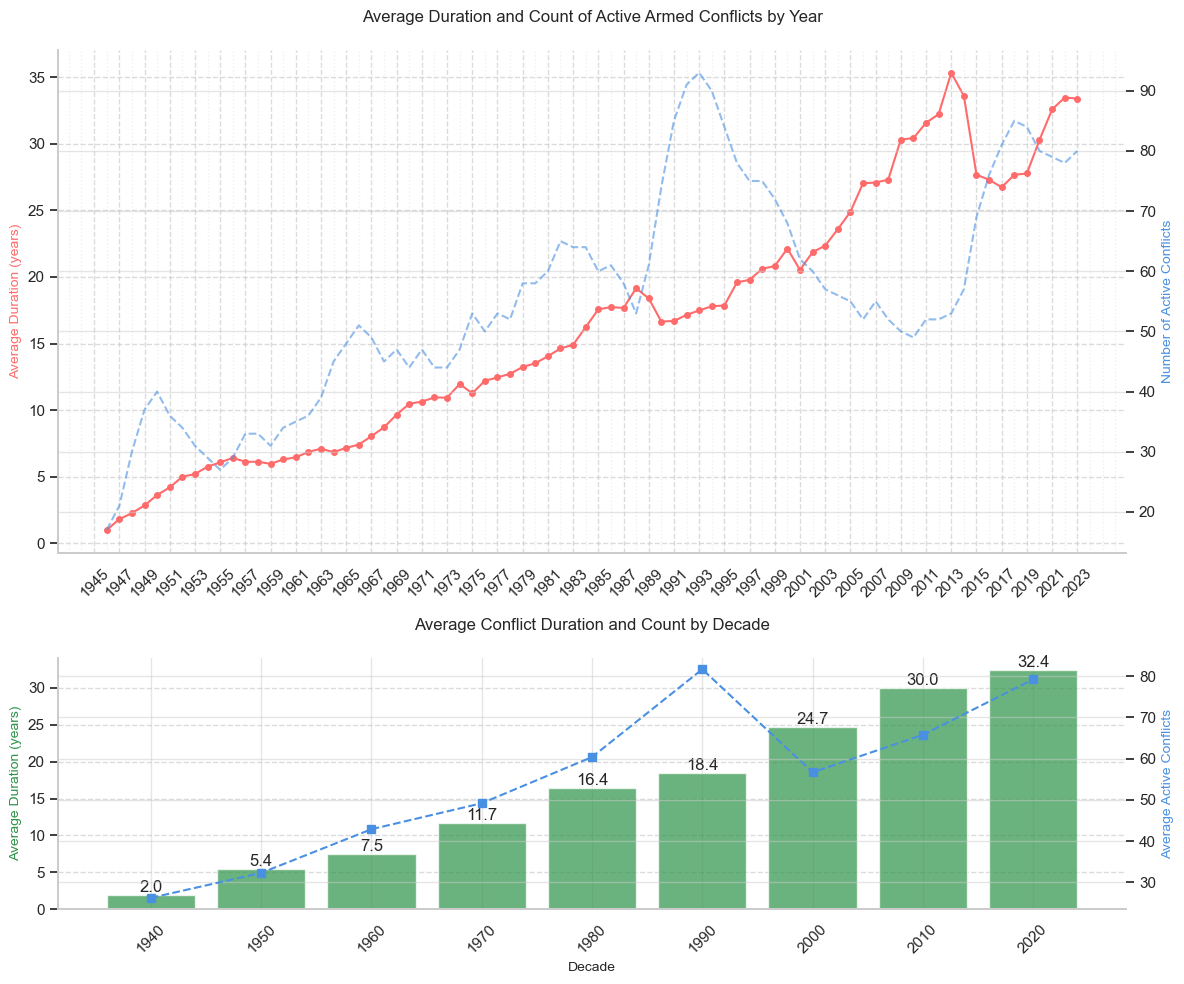

In [3]:
# %%
# jupyter: {'source_hidden': true}
def create_conflict_duration_plots(yearly_avg: pd.DataFrame, 
                                 decade_avg: pd.DataFrame, 
                                 save_fig: bool = False) -> plt.Figure:
    """
    Create visualization of conflict durations with yearly and decade views
    
    Parameters:
    -----------
    yearly_avg : pd.DataFrame
        DataFrame with yearly average durations
    decade_avg : pd.DataFrame
        DataFrame with decade averages
    save_fig : bool
        Whether to save the figure
        
    Returns:
    --------
    plt.Figure
        The generated figure object
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[2, 1])
    
    # Plot 1: Average duration line plot
    ax1.plot(yearly_avg['year'], yearly_avg['avg_duration'], 
            marker='o', linestyle='-', color='#FF6B6B', markersize=4)
    
    # Add number of conflicts as a second y-axis
    ax1_twin = ax1.twinx()
    ax1_twin.plot(yearly_avg['year'], yearly_avg['active_conflicts'],
                 color='#4A90E2', linestyle='--', alpha=0.6)
    
    # Set x-axis markers for yearly plot
    start_year = yearly_avg['year'].min()
    end_year = yearly_avg['year'].max()
    year_ticks = range(start_year - (start_year % 5),  # Round to nearest 5
                      end_year + 1, 
                    2)  # Step of 2 years
    ax1.set_xticks(year_ticks)
    ax1.set_xticklabels(year_ticks, rotation=45)
    
    # Add minor ticks for individual years
    ax1.xaxis.set_minor_locator(plt.MultipleLocator(1))
    ax1.grid(True, which='major', linestyle='--', alpha=0.7)
    ax1.grid(True, which='minor', linestyle=':', alpha=0.3)
    
    # Customize the line plot
    ax1.set_xlabel('')
    ax1.set_ylabel('Average Duration (years)', color='#FF6B6B', fontsize=10)
    ax1_twin.set_ylabel('Number of Active Conflicts', color='#4A90E2', fontsize=10)
    ax1.set_title('Average Duration and Count of Active Armed Conflicts by Year', 
                 fontsize=12, pad=20)
    
    # Plot 2: Decade averages bar plot
    bars = ax2.bar(decade_avg['decade'].astype(str), 
                  decade_avg['avg_duration'],
                  color='#2D9348', alpha=0.7)
    
    # Add decade average conflict counts
    ax2_twin = ax2.twinx()
    ax2_twin.plot(range(len(decade_avg)), decade_avg['active_conflicts'],
                 color='#4A90E2', marker='s', linestyle='--')
    
    # Set x-axis markers for decade plot
    decade_labels = decade_avg['decade'].astype(str)
    ax2.set_xticks(range(len(decade_labels)))
    ax2.set_xticklabels(decade_labels, rotation=45)
    
    # Add minor ticks for mid-decade years
    ax2.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
    ax2.grid(True, which='major', axis='y', linestyle='--', alpha=0.7)
    ax2.grid(True, which='minor', axis='y', linestyle=':', alpha=0.3)
    
    # Customize the bar plot
    ax2.set_xlabel('Decade', fontsize=10)
    ax2.set_ylabel('Average Duration (years)', color='#2D9348', fontsize=10)
    ax2_twin.set_ylabel('Average Active Conflicts', color='#4A90E2', fontsize=10)
    ax2.set_title('Average Conflict Duration and Count by Decade', fontsize=12, pad=20)
    
    # Add value labels on the bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    
    if save_fig:
        plt.savefig('conflict_duration_panel.png', dpi=300, bbox_inches='tight')
    
    return fig

fig = create_conflict_duration_plots(yearly_avg, decade_avg)
plt.show()

<sub><em>Source: [UCDP (Uppsala Conflict Data Program)](https://ucdp.uu.se/)</em></sub>  

## Conflict-induced fatalities by region (ACLED)
XX.

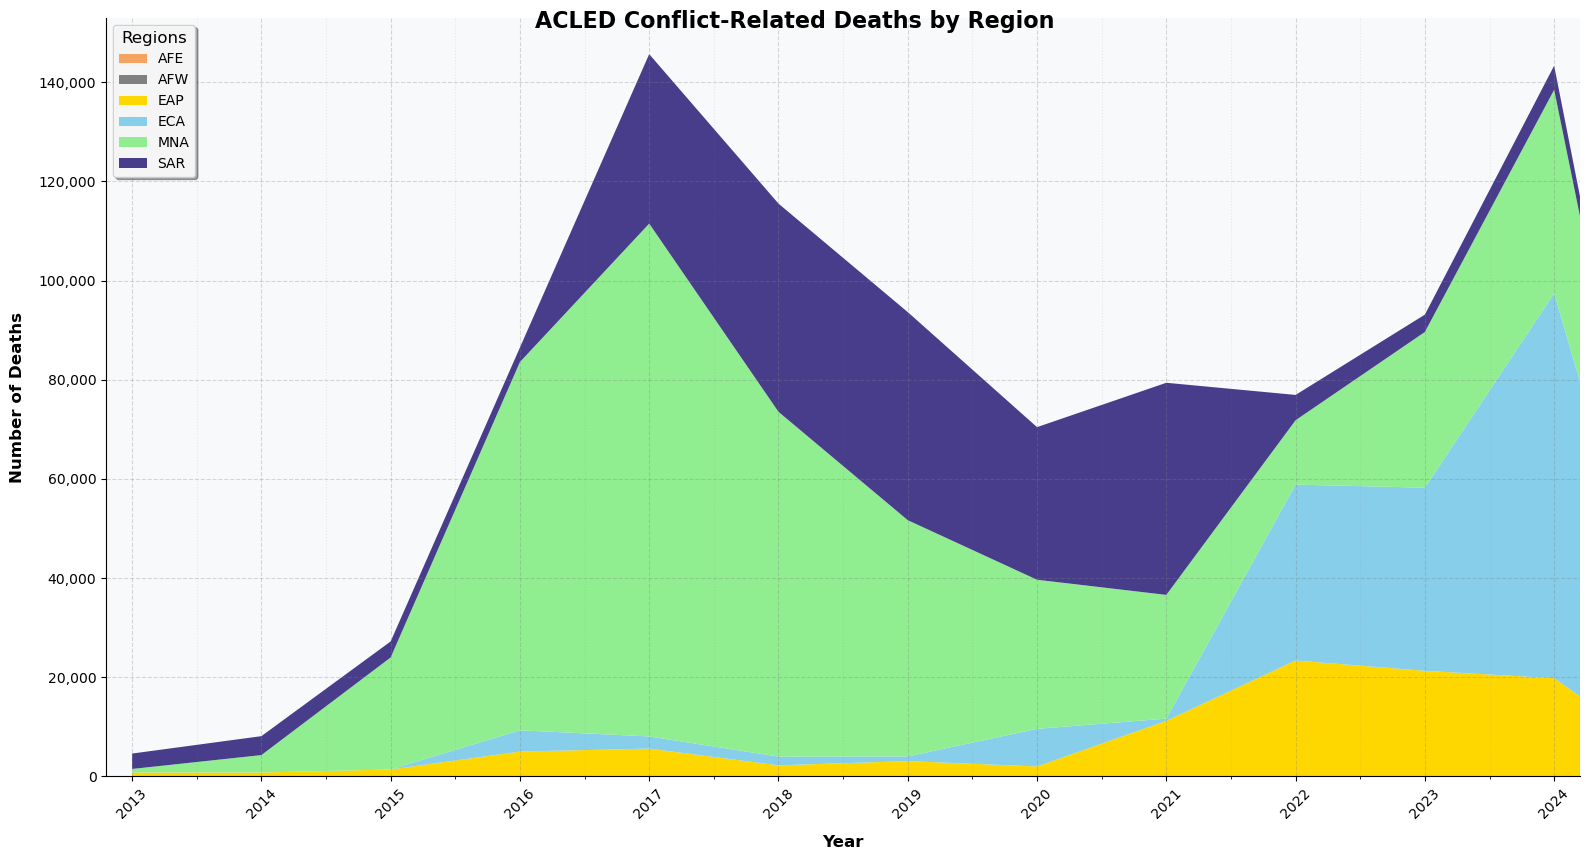

In [4]:
# %%
# jupyter: {'source_hidden': true}
from IPython.display import display, HTML

# Initialize ACLED data fetcher
# Create date objects
# start_date = datetime(2013, 1, 1)
# end_date = datetime(2025, 1, 31)

# # Fetch raw data
# df_acled = acled.fetch_data(start_date, end_date)

# # Process the data
# df_acled_processed = acled.process_data(df_acled)

# # Get conflict-related deaths if needed
# df_acled_crd = acled.get_conflict_related_deaths(df_acled_processed)

# # Get event counts if needed
# df_acled_events = acled.get_event_counts(df_acled_processed)

def plot_acled_regional_deaths(csv_path):
    """
    Create a stacked area plot of ACLED conflict-related deaths by region
    
    Parameters:
    -----------
    csv_path : str
        Path to the CSV file containing ACLED data with columns:
        iso3, year, month, ACLED_conflict_related_deaths, region_code
    """
    # Read the CSV file
    df = pd.read_csv(csv_path)
    
    # Filter for years >= 2013
    df = df[df['year'] >= 2013].copy()
    
    # Group by year and region, sum deaths
    yearly_region_deaths = df.groupby(['year', 'region_code'])['ACLED_conflict_related_deaths'].sum().unstack(fill_value=0)
    
    # Ensure all regions are present
    regions = ['AFE', 'AFW', 'EAP', 'ECA', 'MNA', 'SAR']
    for region in regions:
        if region not in yearly_region_deaths.columns:
            yearly_region_deaths[region] = 0
    
    # Select and order columns
    yearly_region_deaths = yearly_region_deaths[regions]
    
    # Create plot
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.set_facecolor('#F8F9FA')
    fig.patch.set_facecolor('white')
    
    # Color palette
    colors = {
        'AFE': '#F4A460',   # Sandy Brown
        'AFW': '#808080',   # Gray
        'EAP': '#FFD700',   # Gold
        'ECA': '#87CEEB',   # Sky Blue
        'MNA': '#90EE90',   # Light Green
        'SAR': '#483D8B'    # Dark Slate Blue
    }
    
    # Plot stacked area
    ax.stackplot(yearly_region_deaths.index, 
                [yearly_region_deaths[region] for region in regions],
                labels=regions,
                colors=[colors[region] for region in regions])
    
    # Customize axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize=10)
    
    # Set x-axis markers
    start_year = 2013
    end_year = 2024
    
    # Major ticks every year
    major_ticks = range(start_year, end_year + 1)
    ax.set_xticks(major_ticks)
    ax.set_xticklabels(major_ticks, rotation=45)
    
    # Minor ticks for half-years
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
    
    # Enhanced grid system
    ax.grid(True, which='major', linestyle='--', alpha=0.3, color='gray', zorder=0)
    ax.grid(True, which='minor', linestyle=':', alpha=0.15, color='gray', zorder=0)
    
    # Add labels and title
    plt.suptitle('ACLED Conflict-Related Deaths by Region', 
                fontsize=16, fontweight='bold', y=0.95)
    plt.title('',
             fontsize=12, style='italic', alpha=0.7, pad=20)
    ax.set_xlabel('Year', fontsize=12, fontweight='bold', labelpad=10)
    ax.set_ylabel('Number of Deaths', fontsize=12, fontweight='bold', labelpad=10)
    
    # Set axis limits with some padding
    ax.set_xlim(start_year - 0.2, end_year + 0.2)
    
    # Add legend with enhanced styling
    legend = ax.legend(title='Regions',
                      loc='upper left',
                      frameon=True,
                      fancybox=True,
                      shadow=True,
                      fontsize=10,
                      title_fontsize=12)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.9)
    
    # Format y-axis with thousands separator
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Adjust layout
    plt.tight_layout()

    # Add the React component for download functionality
    display(HTML("""
        <div id="acled-plot-container"></div>
        <script>
            const container = document.getElementById('acled-plot-container');
            const root = ReactDOM.createRoot(container);
            root.render(
                React.createElement(ACLEDPlotDownload, {
                    title: 'ACLED Conflict-Related Deaths by Region'
                })
            );
        </script>
    """))    
    
    return plt

# Create the plot
plot = plot_acled_regional_deaths(data_dir / 'acled.csv')
plot.show()


<sub><em>Source: [ACLED (Armed Conflict Location & Event Data Project)](https://acleddata.com/)</em></sub>  

## Conflict-induced fatalities by region including LAC (ACLED)
Most Latin American and Caribbean (LAC) countries were included in the ACLED dataset only after 2019. As a result, conflict event coverage for the region is limited in earlier years, and analyses involving historical trends should account for this data availability constraint..

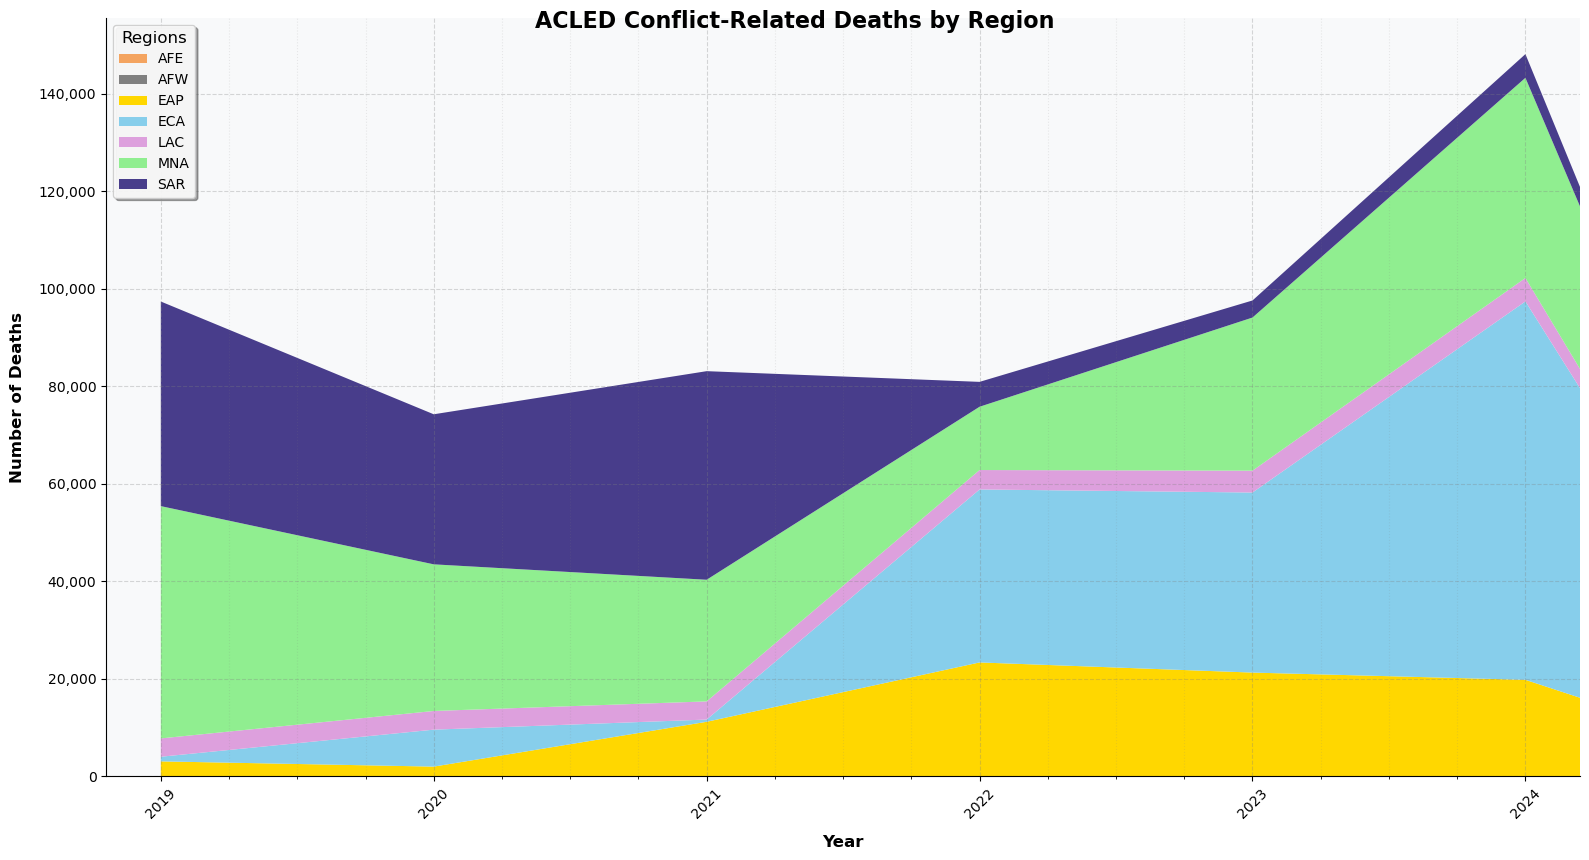

In [5]:
def plot_acled_regional_deaths_lac(csv_path):
    """
    Create a stacked area plot of ACLED conflict-related deaths by region from 2019
    
    Parameters:
    -----------
    csv_path : Path or str
        Path to the CSV file containing ACLED data with columns:
        iso3, year, month, ACLED_conflict_related_deaths, region_code
    """
    # Read the CSV file
    df = pd.read_csv(csv_path)
    
    # Filter for years >= 2019
    df = df[df['year'] >= 2019].copy()
    
    # Group by year and region, sum deaths
    yearly_region_deaths = df.groupby(['year', 'region_code'])['ACLED_conflict_related_deaths'].sum().unstack(fill_value=0)
    
    # Ensure all regions are present
    regions = ['AFE', 'AFW', 'EAP', 'ECA', 'LAC', 'MNA', 'SAR']
    for region in regions:
        if region not in yearly_region_deaths.columns:
            yearly_region_deaths[region] = 0
    
    # Select and order columns
    yearly_region_deaths = yearly_region_deaths[regions]
    
    # Create the plot with enhanced styling
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.set_facecolor('#F8F9FA')
    fig.patch.set_facecolor('white')
    
    # Enhanced color palette
    colors = {
        'AFE': '#F4A460',   # Sandy Brown
        'AFW': '#808080',   # Gray
        'EAP': '#FFD700',   # Gold
        'ECA': '#87CEEB',   # Sky Blue
        'LAC': '#DDA0DD',   # Plum
        'MNA': '#90EE90',   # Light Green
        'SAR': '#483D8B'    # Dark Slate Blue
    }
    
    # Plot stacked area
    ax.stackplot(yearly_region_deaths.index, 
                [yearly_region_deaths[region] for region in regions],
                labels=regions,
                colors=[colors[region] for region in regions])
    
    # Customize axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize=10)
    
    # Set x-axis markers
    start_year = 2019
    end_year = 2024
    
    # Major ticks for each year
    major_ticks = range(start_year, end_year + 1)
    ax.set_xticks(major_ticks)
    ax.set_xticklabels(major_ticks, rotation=45)
    
    # Minor ticks for quarters
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.25))
    
    # Enhanced grid system
    ax.grid(True, which='major', linestyle='--', alpha=0.3, color='gray', zorder=0)
    ax.grid(True, which='minor', linestyle=':', alpha=0.15, color='gray', zorder=0)
    
    # Add labels and title
    plt.suptitle('ACLED Conflict-Related Deaths by Region', 
                fontsize=16, fontweight='bold', y=0.95)
    plt.title('',
             fontsize=12, style='italic', alpha=0.7, pad=20)
    ax.set_xlabel('Year', fontsize=12, fontweight='bold', labelpad=10)
    ax.set_ylabel('Number of Deaths', fontsize=12, fontweight='bold', labelpad=10)
    
    # Set axis limits with padding
    ax.set_xlim(start_year - 0.2, end_year + 0.2)
    
    # Format y-axis with thousands separator
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Add legend with enhanced styling
    legend = ax.legend(title='Regions',
                      loc='upper left',
                      frameon=True,
                      fancybox=True,
                      shadow=True,
                      fontsize=10,
                      title_fontsize=12)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.9)
    
    plt.tight_layout()
    
    return plt

plot = plot_acled_regional_deaths_lac(data_dir / 'acled.csv')
plot.show()


<sub><em>Source: [ACLED (Armed Conflict Location & Event Data Project)](https://acleddata.com/)</em></sub>  

## Conflict-induced fatalities by income (ACLED)


Total conflict-related deaths (2013-2024): 1,392,891

Distribution by income group:
High income: 13,374 deaths (1.0%)
Upper middle income: 297,858 deaths (21.4%)
Lower middle income: 302,610 deaths (21.7%)
Low income: 773,088 deaths (55.5%)
Not classified: 5,961 deaths (0.4%)


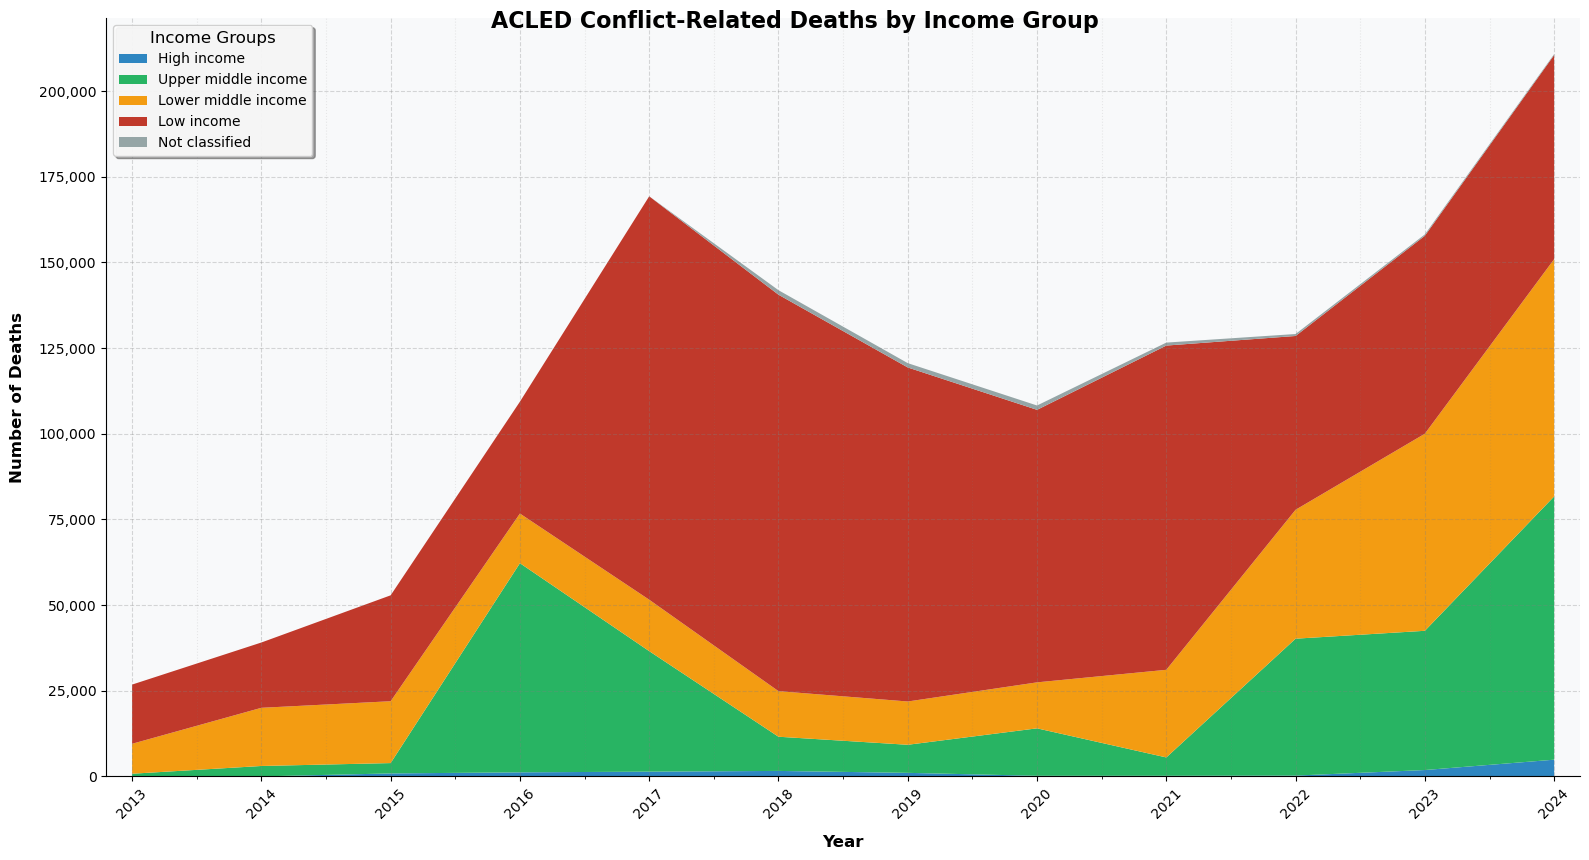

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_acled_income_deaths(acled_path, lend_group_path):
    """
    Create a stacked area plot of ACLED conflict-related deaths by income group
    
    Parameters:
    -----------
    acled_path : Path or str
        Path to the ACLED CSV file with columns: 
        iso3, year, month, ACLED_conflict_related_deaths
    lend_group_path : Path or str
        Path to the lending group Excel file
    """
    # Read data files
    df = pd.read_csv(acled_path)
    lend_group = pd.read_excel(lend_group_path)
    
    # Merge with lending group data
    df = df.merge(lend_group[['Code', 'Income group']], 
                 left_on='iso3', 
                 right_on='Code', 
                 how='left')
    
    # Fill missing income groups
    df['Income group'] = df['Income group'].fillna('Not classified')
    
    # Group by year and income group, sum deaths
    yearly_income_deaths = df.groupby(
        ['year', 'Income group'])['ACLED_conflict_related_deaths'].sum().unstack(fill_value=0)
    
    # Define income groups in desired order
    income_groups = [
        'High income',
        'Upper middle income',
        'Lower middle income',
        'Low income',
        'Not classified'
    ]
    
    # Ensure all income groups are present
    for group in income_groups:
        if group not in yearly_income_deaths.columns:
            yearly_income_deaths[group] = 0
    
    # Select and order columns
    yearly_income_deaths = yearly_income_deaths[income_groups]
    
    # Filter for years 2013-2024
    yearly_income_deaths = yearly_income_deaths.loc[2013:2024]
    
    # Create plot
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.set_facecolor('#F8F9FA')
    fig.patch.set_facecolor('white')
    
    # Color palette for income groups
    colors = {
        'High income': '#2E86C1',        # Blue
        'Upper middle income': '#28B463', # Green
        'Lower middle income': '#F39C12', # Orange
        'Low income': '#C0392B',         # Red
        'Not classified': '#95A5A6'       # Gray
    }
    
    # Plot stacked area
    ax.stackplot(yearly_income_deaths.index, 
                [yearly_income_deaths[group] for group in income_groups],
                labels=income_groups,
                colors=[colors[group] for group in income_groups])
    
    # Customize axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize=10)
    
    # Set x-axis markers
    start_year = 2013
    end_year = 2024
    
    # Major ticks every year
    major_ticks = range(start_year, end_year + 1)
    ax.set_xticks(major_ticks)
    ax.set_xticklabels(major_ticks, rotation=45)
    
    # Minor ticks for half-years
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
    
    # Enhanced grid system
    ax.grid(True, which='major', linestyle='--', alpha=0.3, color='gray', zorder=0)
    ax.grid(True, which='minor', linestyle=':', alpha=0.15, color='gray', zorder=0)
    
    # Add labels and title
    plt.suptitle('ACLED Conflict-Related Deaths by Income Group', 
                fontsize=16, fontweight='bold', y=0.95)
    plt.title('',
             fontsize=12, style='italic', alpha=0.7, pad=20)
    ax.set_xlabel('Year', fontsize=12, fontweight='bold', labelpad=10)
    ax.set_ylabel('Number of Deaths', fontsize=12, fontweight='bold', labelpad=10)
    
    # Set axis limits with padding
    ax.set_xlim(start_year - 0.2, end_year + 0.2)
    
    # Add legend with enhanced styling
    legend = ax.legend(title='Income Groups',
                      loc='upper left',
                      frameon=True,
                      fancybox=True,
                      shadow=True,
                      fontsize=10,
                      title_fontsize=12)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.9)
    
    # Format y-axis with thousands separator
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Calculate and print summary statistics
    total_deaths = yearly_income_deaths.sum().sum()
    print(f"\nTotal conflict-related deaths (2013-2024): {total_deaths:,.0f}")
    
    print("\nDistribution by income group:")
    for group in income_groups:
        group_total = yearly_income_deaths[group].sum()
        percentage = (group_total / total_deaths) * 100
        print(f"{group}: {group_total:,.0f} deaths ({percentage:.1f}%)")
    
    # Adjust layout
    plt.tight_layout()
    
    return plt

plot = plot_acled_income_deaths(
    data_dir / 'acled.csv',
    data_dir / 'lend_group.xlsx'
)
plot.show()

<sub><em>Source: [ACLED (Armed Conflict Location & Event Data Project)](https://acleddata.com/)</em></sub>  

## Conflict-induced fatalities by type of conflict (UCDP)
XX.

C:\Users\wb617270\AppData\Local\Temp\ipykernel_20296\89050950.py:147: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot.show()


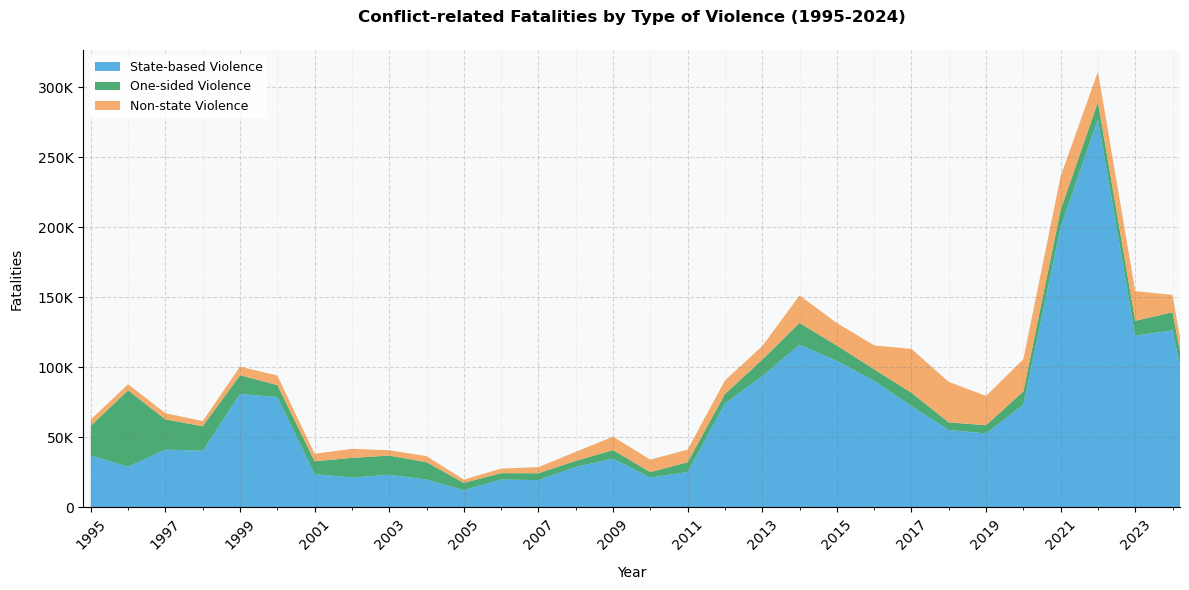

In [14]:
# %%
# jupyter: {'source_hidden': true}
# Fetch fatalities data for a specific period
# fatalities_df = ucdp.fetch_fatalities_data(
#     start_date='1995-11-01',
#     end_date='2024-12-31'
# )
# df_fat = ucdp.process_fatalities_data(fatalities_df) 

import os
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional
def plot_ucdp_fatalities(df: pd.DataFrame, 
                          output_path: Optional[str] = None) -> plt.Figure:
    """
    Create a stacked area plot of fatalities by violence type using UCDP data
    
    Parameters:
    -----------
    df : pd.DataFrame
        Processed UCDP fatalities data 
    output_path : str, optional
        If provided, save the plot to this path
        
    Returns:
    --------
    plt.Figure
        The matplotlib figure object
    """
    # Filter data from 1995 onwards
    df = df[df.index >= 1995]
    
    # Create the figure with higher resolution
    fig = plt.figure(figsize=(12, 6), dpi=100)
    ax = plt.gca()
    
    # Extract data for each violence type
    years = df.index
    state_based = df['UCDP_BRD_state_based']
    one_sided = df['UCDP_BRD_one_sided']
    non_state = df['UCDP_BRD_non_state']
    
    # Create stacked area plot with enhanced colors and alpha
    plt.stackplot(years, 
                 [state_based, one_sided, non_state],
                 labels=['State-based Violence', 'One-sided Violence', 'Non-state Violence'],
                 colors=['#2D9CDB', '#219653', '#F2994A'],  # Blue, Green, Orange
                 alpha=0.8)
    
    # Set x-axis markers
    start_year = 1995
    end_year = 2024
    
    # Major ticks every 5 years
    major_ticks = range(start_year - (start_year % 5), end_year + 1, 2)
    ax.set_xticks(major_ticks)
    ax.set_xticklabels(major_ticks, rotation=45)
    
    # Minor ticks for individual years
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
    
    # Enhanced grid system
    ax.grid(True, which='major', linestyle='--', alpha=0.3, color='gray')
    ax.grid(True, which='minor', linestyle=':', alpha=0.15, color='gray')
    
    # Customize the plot
    plt.xlabel('Year', fontsize=10, labelpad=10)
    plt.ylabel('Fatalities', fontsize=10, labelpad=10)
    
    # Format y-axis with thousands
    def format_func(x, p):
        if x >= 1000000:
            return f'{x/1000000:.1f}M'
        elif x >= 1000:
            return f'{x/1000:.0f}K'
        else:
            return f'{int(x):,}'
    
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    
    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Customize legend
    plt.legend(loc='upper left', frameon=True, framealpha=0.9, 
              facecolor='white', edgecolor='none', fontsize=9)
    
    # Add title
    plt.title('Conflict-related Fatalities by Type of Violence (1995-2024)', 
             pad=20, fontsize=12, fontweight='bold')
    
    # Set x-axis limits with padding
    plt.xlim(start_year - 0.2, end_year + 0.2)
    
    # Add subtle background color
    plt.gca().set_facecolor('#f8f9fa')
    plt.gcf().patch.set_facecolor('white')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if output path is provided
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=300, 
                   facecolor='white', edgecolor='none')
        print(f"Plot saved to {output_path}")
    
    return fig

# Rest of the code remains the same
def prepare_ucdp_fatalities_data(data_dir: str):
    """
    Prepare UCDP fatalities data for plotting
    
    Parameters:
    -----------
    data_dir : str
        Directory containing the UCDP data file
    
    Returns:
    --------
    pd.DataFrame
        Processed UCDP fatalities data aggregated by year
    """
    # Construct file path
    ucdp_path = os.path.join(data_dir, 'ucdp.csv')
    
    # Read data
    df = pd.read_csv(ucdp_path)
    
    # Group by year and sum fatalities
    yearly_fatalities = df.groupby('year').agg({
        'UCDP_BRD_state_based': 'sum',
        'UCDP_BRD_non_state': 'sum',
        'UCDP_BRD_one_sided': 'sum'
    }).reset_index()
    
    # Set year as index
    yearly_fatalities.set_index('year', inplace=True)
    
    return yearly_fatalities

df_fat = prepare_ucdp_fatalities_data(data_dir)
plot = plot_ucdp_fatalities(df_fat)
plot.show()

<sub><em>Source: [UCDP (Uppsala Conflict Data Program)](https://ucdp.uu.se/)</em></sub>  

## UCDP by income group
XX.

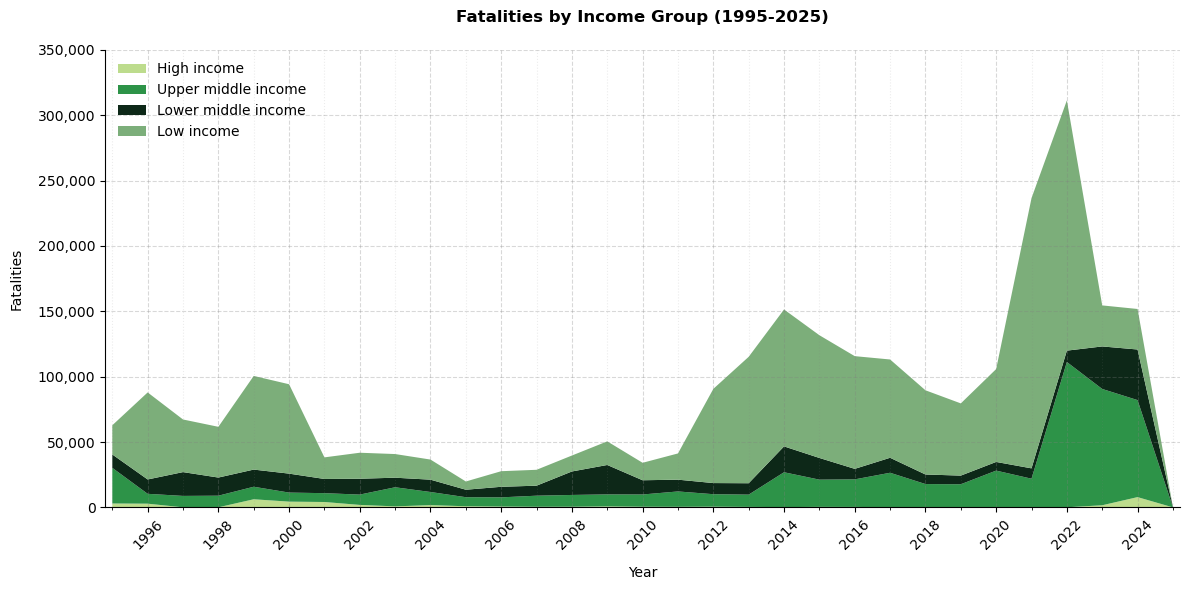

In [16]:
# %%
# jupyter: {'source_hidden': true}
def plot_fatalities_by_income(data_dir: str):
    """
    Create a stacked area plot of total fatalities by income group
    
    Parameters:
    -----------
    data_dir : str
        Directory containing both UCDP and lending group data
    """
    # Construct file paths
    ucdp_path = os.path.join(data_dir, 'ucdp.csv')
    lend_group_path = os.path.join(data_dir, 'lend_group.xlsx')
    
    # Read data
    ucdp = pd.read_csv(ucdp_path, usecols=['iso3', 'year', 'UCDP_BRD'])
    lend_group = pd.read_excel(lend_group_path)
    
    # Merge datasets
    df = ucdp.merge(lend_group[['Code', 'Income group']], 
                    left_on='iso3', 
                    right_on='Code', 
                    how='left')
    
    # Group by year and income group, sum fatalities
    yearly_fatalities = df.groupby(['year', 'Income group'])['UCDP_BRD'].sum().reset_index()
    
    # Pivot data for plotting
    fatalities_pivot = yearly_fatalities.pivot(
        index='year',
        columns='Income group',
        values='UCDP_BRD'
    )
    
    # Create the figure
    fig = plt.figure(figsize=(12, 6))
    ax = plt.gca()
    
    # Set start year to 1995 and get end year from data
    start_year = 1995
    end_year = fatalities_pivot.index.max()
    
    # Filter years from 1995 onwards
    fatalities_pivot = fatalities_pivot[
        (fatalities_pivot.index >= start_year) & 
        (fatalities_pivot.index <= end_year)
    ]
    years = fatalities_pivot.index
    
    income_groups = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']
    
    # Filter and reorder columns based on income groups that exist in the data
    available_groups = [group for group in income_groups if group in fatalities_pivot.columns]
    fatalities_data = [fatalities_pivot[group].fillna(0) for group in available_groups]
    
    # Define colors for income groups
    colors = ['#BDDC8D', '#2D9348', '#0D2818', '#7CAE7A']  # Light green to dark green
    
    # Create stacked area plot
    plt.stackplot(years, 
                 fatalities_data,
                 labels=available_groups,
                 colors=colors[:len(available_groups)])
    
    # Major ticks every 2 years
    major_ticks = range(start_year - (start_year % 2), end_year + 1, 2)
    ax.set_xticks(major_ticks)
    ax.set_xticklabels(major_ticks, rotation=45)
    
    # Minor ticks for years in between
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
    
    # Enhanced grid system
    ax.grid(True, which='major', axis='both', linestyle='--', alpha=0.3, color='gray')
    ax.grid(True, which='minor', axis='both', linestyle=':', alpha=0.15, color='gray')
    
    # Customize the plot
    plt.xlabel('Year', labelpad=10)
    plt.ylabel('Fatalities', rotation=90, labelpad=10)
    
    # Format y-axis with thousands
    plt.gca().yaxis.set_major_formatter(
        plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
    
    # Add thousands separator to y-axis labels
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticks(current_values)
    
    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Customize legend
    plt.legend(loc='upper left', frameon=False)
    
    # Set x-axis limits with padding
    plt.xlim(start_year - 0.2, end_year + 0.2)
    
    # Add title
    plt.title(f'Fatalities by Income Group ({start_year}-{end_year})',
             pad=20, fontsize=12, fontweight='bold')
    
    # Adjust layout
    plt.tight_layout()
    
    return plt

plot = plot_fatalities_by_income(data_dir)
plot.show()

<sub><em>Source: [UCDP (Uppsala Conflict Data Program)](https://ucdp.uu.se/)</em></sub>  

# Coups
## Global Coup Attempts
XX.

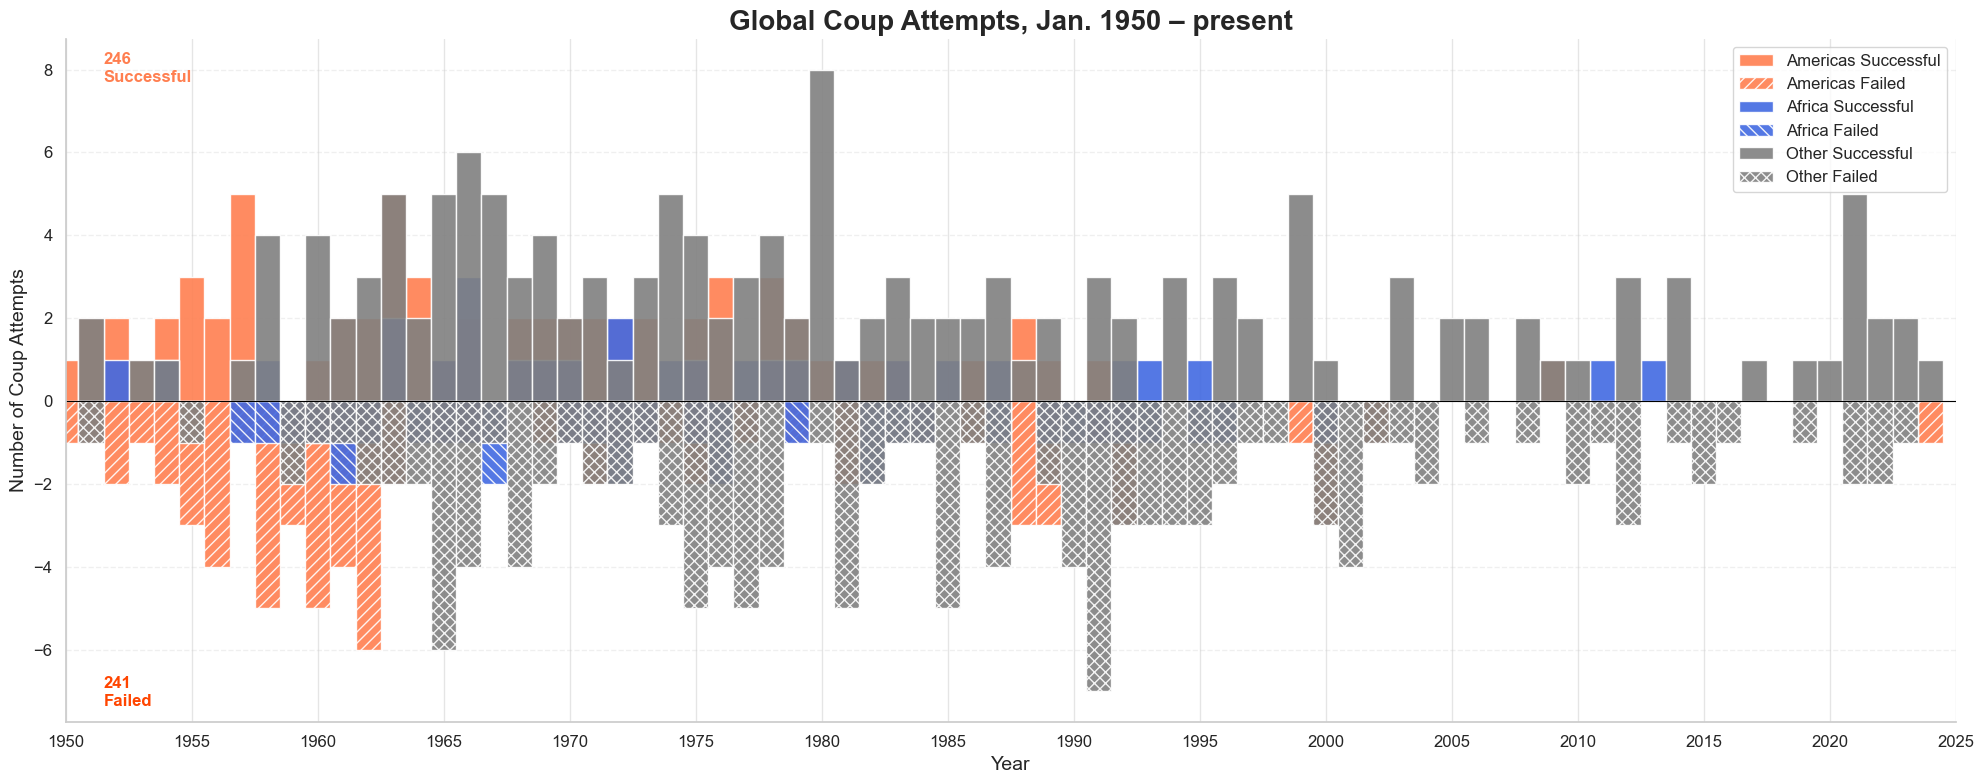

In [8]:
# %%
# jupyter: {'source_hidden': true}
# # Fetch GIC data
df_gic = gic.processed_data

def plot_global_coup_attempts(data, start_year=1950, end_year=2025):
    """
    Create a visualization of global coup attempts with patterns for failed coups
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Processed coup data 
    start_year : int, optional
        Starting year for the plot (default is 1950)
    end_year : int, optional
        Ending year for the plot to nowadays
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Create figure with specific dimensions
    fig, ax = plt.subplots(figsize=(20, 8), dpi=100)
    
    # Filter data for specified year range
    plot_data = data[
        (data['year'] >= start_year) & 
        (data['year'] <= end_year)
    ]
    
    # Group data by year, region, and coup status
    yearly_data = plot_data.groupby(['year', 'region', 'coup_status']).size().reset_index(name='count')
    
    # Color palette and hatch patterns
    colors = {
        ('Americas', 2): '#FF7F50',   # Coral for successful Americas coups
        ('Americas', 1): '#FF7F50',   # Same color for failed but with pattern
        ('Africa', 2): '#4169E1',     # Royal blue for successful Africa coups
        ('Africa', 1): '#4169E1',     # Same color for failed but with pattern
        ('Other', 2): '#808080',      # Gray for successful Other coups
        ('Other', 1): '#808080'       # Same color for failed but with pattern
    }
    
    # Hatch patterns for failed coups
    hatches = {
        'Americas': '///',
        'Africa': '\\\\\\',
        'Other': 'xxx'
    }
    
    # Regions to plot
    regions = ['Americas', 'Africa', 'Other']
    
    # Plot each region's coups
    for region in regions:
        region_data = yearly_data[yearly_data['region'] == region]
        
        # Successful coups (above zero)
        successful = region_data[region_data['coup_status'] == 2]
        for _, row in successful.iterrows():
            ax.bar(row['year'], row['count'], 
                  color=colors.get((region, 2)), 
                  alpha=0.9, 
                  width=1, 
                  label=f'{region} Successful' if row['year'] == successful.iloc[0]['year'] else "")
        
        # Failed coups (below zero)
        failed = region_data[region_data['coup_status'] == 1]
        for _, row in failed.iterrows():
            ax.bar(row['year'], -row['count'], 
                  color=colors.get((region, 1)), 
                  alpha=0.9, 
                  width=1,
                  hatch=hatches[region],
                  label=f'{region} Failed' if row['year'] == failed.iloc[0]['year'] else "")
    
    # Styling
    ax.set_title('Global Coup Attempts, Jan. 1950 – present', fontsize=20, fontweight='bold')
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Number of Coup Attempts', fontsize=14)
    
    # X-axis setup
    ax.set_xlim(start_year, end_year)
    ax.set_xticks(np.arange(start_year, end_year+1, 5))
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Grid
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)
    
    # Zero line
    ax.axhline(y=0, color='black', linewidth=0.8)
    
    # Total coup annotations
    successful_total = yearly_data[yearly_data['coup_status'] == 2]['count'].sum()
    failed_total = yearly_data[yearly_data['coup_status'] == 1]['count'].sum()
    
    ax.text(0.02, 0.98, f'{successful_total}\nSuccessful', transform=ax.transAxes, 
            verticalalignment='top', fontsize=12, fontweight='bold', color='#FF7F50')
    ax.text(0.02, 0.02, f'{failed_total}\nFailed', transform=ax.transAxes, 
            verticalalignment='bottom', fontsize=12, fontweight='bold', color='#FF4500')
    
    # Add legend with custom ordering
    handles, labels = ax.get_legend_handles_labels()
    # Reorder to group by region
    order = ['Americas Successful', 'Americas Failed',
             'Africa Successful', 'Africa Failed',
             'Other Successful', 'Other Failed']
    ordered_handles = []
    ordered_labels = []
    for label in order:
        idx = labels.index(label)
        ordered_handles.append(handles[idx])
        ordered_labels.append(labels[idx])
    
    ax.legend(ordered_handles, ordered_labels, 
             loc='upper right', 
             fontsize=12, 
             frameon=True)
    
    plt.tight_layout()
    return plt

# Example usage
if __name__ == '__main__':
    plt = plot_global_coup_attempts(df_gic)
    plt.show()

<sub><em>Source: [Global Instances of Coups (GIC)](https://jonathanmpowell.com/coups/) — Powell, Jonathan & Clayton Thyne. 2011. *Global Instances of Coups from 1950-Present*. Journal of Peace Research 48(2):249-259.</em></sub>

# Displacement
## Forcibly Displaced Persons
XX.

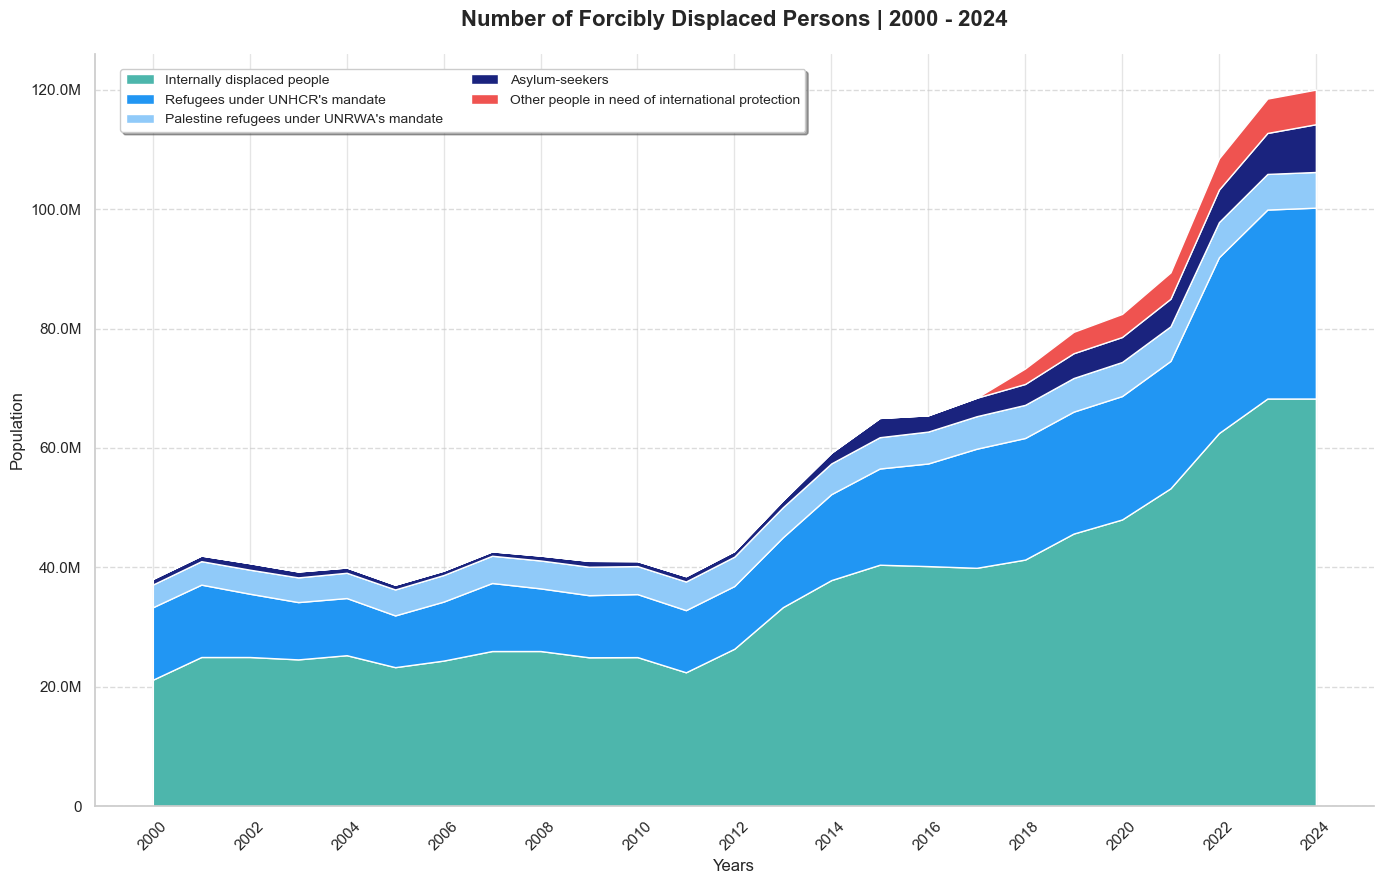

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

def prepare_data_for_plotting(df_unhcr):
    """
    Prepare the data for plotting by ensuring correct types and handling missing values
    
    Parameters:
    -----------
    df_unhcr : pd.DataFrame
        Input DataFrame from UNHCR data
        
    Returns:
    --------
    pd.DataFrame
        Processed DataFrame ready for plotting
    """
    # List of columns that should be numeric
    numeric_cols = ['refugees_unhcr', 'asylum_seekers', 'other_protection', 
                   'refugees_unrwa', 'idps']
    
    # Create a copy to avoid modifying the original
    plot_df = df_unhcr.copy()
    
    # Convert numeric columns and replace '-' with 0
    for col in numeric_cols:
        # Replace '-' with 0
        if col in plot_df.columns:
            plot_df[col] = plot_df[col].replace('-', 0)
            # Convert to numeric, replacing errors with 0
            plot_df[col] = pd.to_numeric(plot_df[col], errors='coerce').fillna(0)
    
    return plot_df

def plot_forced_displacement(df_input, output_path=None):
    """
    Create a stacked area plot of forced displacement data
    
    Parameters:
    -----------
    df_input : pd.DataFrame
        DataFrame containing columns: year, refugees_unhcr, asylum_seekers,
        other_protection, refugees_unrwa, idps
    output_path : str, optional
        If provided, save the plot to this path
    """
    # Prepare data
    plot_df = prepare_data_for_plotting(df_input)
    
    # Create the figure with specified size and extra space for legend
    plt.figure(figsize=(14, 9))
    
    # Get the years for x-axis
    years = plot_df['year']
    
    # Prepare the data arrays
    idps = plot_df['idps'].values
    refugees_unhcr = plot_df['refugees_unhcr'].values
    refugees_unrwa = plot_df['refugees_unrwa'].values
    asylum_seekers = plot_df['asylum_seekers'].values
    other_protection = plot_df.get('other_protection', 
                                   pd.Series([0] * len(years))).values
    
    # Create stacked area plot
    plt.stackplot(years,
                 [idps, refugees_unhcr, refugees_unrwa, asylum_seekers, other_protection],
                 labels=['Internally displaced people',
                        'Refugees under UNHCR\'s mandate',
                        'Palestine refugees under UNRWA\'s mandate',
                        'Asylum-seekers',
                        'Other people in need of international protection'],
                 colors=['#4DB6AC',    # Turquoise for IDPs
                        '#2196F3',     # Blue for UNHCR refugees
                        '#90CAF9',     # Light blue for UNRWA refugees
                        '#1A237E',     # Dark blue for asylum seekers
                        '#EF5350'])    # Red for other protection
    
    # Customize the plot
    plt.title('Number of Forcibly Displaced Persons | 2000 - 2024', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Years', fontsize=12)
    plt.ylabel('Population', fontsize=12)
    
    # Format y-axis with millions
    def millions_formatter(x, pos):
        """Format large numbers in millions"""
        if x >= 1_000_000:
            return f'{x/1_000_000:.1f}M'
        elif x >= 1_000:
            return f'{x/1_000:.1f}K'
        return f'{x:.0f}'
    
    plt.gca().yaxis.set_major_formatter(
        plt.FuncFormatter(millions_formatter))
    
    # Set x-axis ticks to show all years
    plt.xticks(years[::2], years[::2], rotation=45)
    
    # Customize grid
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Position legend inside the plot at top left corner
    plt.legend(loc='upper left',
              bbox_to_anchor=(0.02, 0.98),  # Fixed position at top left
              ncol=2,  # 2 columns
              borderaxespad=0,
              frameon=True,  # Add frame around legend
              fancybox=True,  # Rounded corners
              shadow=True,    # Add shadow
              fontsize=10)    # Adjust font size
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Save if output path is provided
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
        
    return plt

if __name__ == "__main__":
    # Initialize UNHCR client
    unhcr = UNHCRDataFinder()
    
    # Get processed displacement data
    df_unhcr = unhcr.process_displacement_data(2000, 2024)
    
    # Create the plot
    plot = plot_forced_displacement(df_unhcr)
    plot.show()

<sub><em>Source: [UNHCR (United Nations High Commissioner for Refugees)](https://www.unhcr.org/data.html) & [IDMC (Internal Displacement Monitoring Centre)](https://www.internal-displacement.org/)</em></sub>


## Forcibly Displaced Persons and Refugees by Income Level

In [ ]:
import pandas as pd
import requests
import time
import numpy as np
from pathlib import Path
from typing import Dict, List, Optional

import time

def make_request(endpoint: str, params: Dict = None) -> Dict:
    base_url = "https://api.unhcr.org/population/v1"
    headers = {"Accept": "application/json"}
    url = f"{base_url}/{endpoint}"
    
    max_retries = 3
    retry_delay = 5
    
    for attempt in range(max_retries):
        try:
            full_url = requests.Request('GET', url, params=params).prepare().url
            
            response = requests.get(url, headers=headers, params=params)
            response.raise_for_status()
            data = response.json()

            return data
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data from {endpoint}: {str(e)}")
            print(f"URL: {url}")
            print(f"Params: {params}")
            if hasattr(e.response, 'text'):
                print(f"Response text: {e.response.text}")
            
            if attempt < max_retries - 1:
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print("Max retries reached. Giving up.")
                return None
    
def fetch_paginated_data(endpoint: str, params: Dict = None) -> List[Dict]:
    if params is None:
        params = {}
    
    params['limit'] = params.get('limit', 1000)
    params['page'] = 1
    params['coo_all'] = 'true'
    params['coa_all'] = 'true'
    
    all_data = []
    
    while True:
        response = make_request(endpoint, params)
        if not response or 'items' not in response or len(response['items']) == 0:
            print(f"No more items found for {endpoint}, stopping at page {params['page']}")
            break
        
        all_data.extend(response['items'])
      
        params['page'] += 1
        time.sleep(0.1)
    
    return all_data

def get_comprehensive_displacement_data(
    data_dir: Path, 
    year_from: Optional[int] = None, 
    year_to: Optional[int] = None
) -> pd.DataFrame:
    params = {}
    if year_from:
        params['yearFrom'] = year_from
    if year_to:
        params['yearTo'] = year_to
    
    print(f"Fetching data with params: {params}")
    
    population_data = fetch_paginated_data('population', params)
    print(f"Fetched {len(population_data)} population data items")
    
    unrwa_data = fetch_paginated_data('unrwa', params)
    print(f"Fetched {len(unrwa_data)} UNRWA data items")
    
    idp_data = fetch_paginated_data('idmc', params)
    print(f"Fetched {len(idp_data)} IDP data items")
    
    # Convert to DataFrames
    population_df = pd.DataFrame(population_data)
    unrwa_df = pd.DataFrame(unrwa_data)
    idp_df = pd.DataFrame(idp_data)

    # Manual mapping for countries with different codes
    country_code_mapping = {
        'ALG': 'DZA',   # Algeria
        'ANG': 'AGO',   # Angola
        'AUL': 'AUS',   # Australia
        'BAH': 'BHR',   # Bahrain
        'BKF': 'BFA',   # Burkina Faso
        'BOT': 'BWA',   # Botswana
        'BRU': 'BRN',   # Brunei
        'BSN': 'BIH',   # Bosnia and Herzegovina
        'BUL': 'BGR',   # Bulgaria
        'BZE': 'BLZ',   # Belize
        'CAM': 'KHM',   # Cambodia
        'CAR': 'CAF',   # Central African Republic
        'CAY': 'CYM',   # Cayman Islands
        'CHD': 'TCD',   # Chad
        'CHI': 'CHL',   # Chile
        'COB': 'COG',   # Congo
        'COS': 'CRI',   # Costa Rica
        'ERT': 'ERI',   # Eritrea
        'GAZ': 'PSE',   # Gaza (Palestinian Territories)
        'ICO': 'CIV',   # Ivory Coast
        'INS': 'IDN',   # Indonesia
        'LEB': 'LBN',   # Lebanon
        'MCD': 'MKD',   # North Macedonia
        'MYA': 'MMR',   # Myanmar
        'NEP': 'NPL',   # Nepal
        'NGR': 'NGA',   # Nigeria
        'PHI': 'PHL',   # Philippines
        'SUD': 'SDN',   # Sudan
        'TMP': 'TLS',   # Timor-Leste
        'TOG': 'TGO',   # Togo
        'GUA': 'GTM',   # Guatemala
        'NIG': 'NER',   # Niger
        'HON': 'HND',   # Honduras
        'UKN': 'UKR',   # Ukraine
        'MAD': 'MDG',   # Madagascar
        'HAI': 'HTI',   # Haiti
        'MLW': 'MWI',   # Malawi
        'RSA': 'ZAF',   # South Africa
        'GAM': 'GMB',   # Gambia
        'SAL': 'SLV',   # El Salvador
        'FNC': 'UNK',   # Unknown code (placeholder)
        'SLN': 'SHN',   # Saint Helena
        'DEN': 'DNK',   # Denmark
        'DJB': 'DJI',   # Djibouti
        'FIJ': 'FJI',   # Fiji
        'GFR': 'FRA',   # France
        'GRE': 'GRC',   # Greece
        'GRN': 'GRD',   # Grenada
        'GUI': 'GIN',   # Guinea
        'ICE': 'ISL',   # Iceland
        'IRE': 'IRL',   # Ireland
        'KUW': 'KWT',   # Kuwait
        'LES': 'LSO',   # Lesotho
        'MAU': 'MUS',   # Mauritius
        'MLS': 'MLT',   # Malta
        'MOR': 'MAR',   # Morocco
        'MTA': 'MNE',   # Montenegro
        'MTS': 'MRT',   # Mauritania
        'NET': 'NLD',   # Netherlands
        'PAR': 'PRY',   # Paraguay
        'POR': 'PRT',   # Portugal
        'ROM': 'ROU',   # Romania
        'SIN': 'SGP',   # Singapore
        'SPA': 'ESP',   # Spain
        'SRV': 'SRB',   # Serbia
        'SWA': 'SWZ',   # Eswatini (Swaziland)
        'SWI': 'CHE',   # Switzerland
        'TAN': 'TZA',   # Tanzania
        'TCI': 'TCA',   # Turks and Caicos Islands
        'TRT': 'TTO',   # Trinidad and Tobago
        'UAE': 'ARE',   # United Arab Emirates
        'URU': 'URY',   # Uruguay
        'VAN': 'VUT',   # Vanuatu
        'ZAM': 'ZMB',   # Zambia
        'ZIM': 'ZWE'    # Zimbabwe
    }
    
    # Apply country code mapping
    population_df['coa'] = population_df['coa'].map(lambda x: country_code_mapping.get(x, x))
    unrwa_df['coa'] = unrwa_df['coa'].map(lambda x: country_code_mapping.get(x, x))
    idp_df['coa'] = idp_df['coa'].map(lambda x: country_code_mapping.get(x, x))
        
    
    # Print columns to debug
    print("Population columns:", population_df.columns)
    print("UNRWA columns:", unrwa_df.columns)
    print("IDP columns:", idp_df.columns)
    
    # Columns to keep and rename
    population_cols = [
        'year', 
        'coo', 
        'coa', 
        'refugees', 
        'asylum_seekers', 
        'oip'
    ]
    
    unrwa_cols = [
        'year', 
        'coo', 
        'coa',
        'total'
    ]
    
    idp_cols = [
        'year', 
        'coo', 
        'coa',
        'total'
    ]
    
    # Ensure all required columns exist
    population_df = population_df[[col for col in population_cols if col in population_df.columns]]
    unrwa_df = unrwa_df[[col for col in unrwa_cols if col in unrwa_df.columns]]
    idp_df = idp_df[[col for col in idp_cols if col in idp_df.columns]]
    
    # Rename columns
    population_df = population_df.rename(columns={
        'refugees': 'refugees_unhcr',
        'oip': 'other_protection'
    })
    unrwa_df = unrwa_df.rename(columns={
        'total': 'refugees_unrwa'
    })
    idp_df = idp_df.rename(columns={
        'total': 'idps'
    })
    
    # Ensure numeric columns
    numeric_cols = [
        'refugees_unhcr', 'asylum_seekers', 'other_protection', 
        'refugees_unrwa', 'idps'
    ]
    for df in [population_df, unrwa_df, idp_df]:
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    
    # Merge DataFrames
    # Use a full outer join with all columns
    merged_dfs = []
    for df in [population_df, unrwa_df, idp_df]:
        if not df.empty:
            merged_dfs.append(df)
    
    if not merged_dfs:
        raise ValueError("No data found in any of the dataframes")
    
    merged_df = merged_dfs[0]
    for df in merged_dfs[1:]:
        merged_df = pd.merge(
            merged_df, 
            df, 
            on=['year', 'coo', 'coa'], 
            how='outer'
        )
    
    # Fill NaN with 0 for numeric columns
    for col in numeric_cols:
        if col in merged_df.columns:
            merged_df[col] = merged_df[col].fillna(0)
    
    # Collapse data at coa-year level
    agg_dict = {}
    for col in numeric_cols:
        if col in merged_df.columns:
            agg_dict[col] = 'sum'
    
    collapsed_df = merged_df.groupby(['year', 'coa']).agg(agg_dict).reset_index()
    
        # Load World Bank income levels
    income_df = pd.read_csv(data_dir / 'wbg-income-levels.csv')
    
    # Preprocess income levels data
    income_df = (income_df
        .sort_values(['year', 'month'])
        .groupby(['year', 'iso3'])
        .last()
        .reset_index()
    )

    # Diagnostic print to understand merge issues
    print("\nUnique COA in displacement data:")
    print(collapsed_df['coa'].unique())
    
    print("\nUnique ISO3 in income levels data:")
    print(income_df['iso3'].unique())

    # Try different merge strategies
    # 1. First, try direct merge on 'coa'
    final_df = pd.merge(
        collapsed_df, 
        income_df[['year', 'iso3', 'WBG_income_level']], 
        left_on=['year', 'coa'], 
        right_on=['year', 'iso3'], 
        how='left'
    )

    # 2. If that doesn't work, identify which countries are missing
    missing_countries = collapsed_df[~collapsed_df['coa'].isin(income_df['iso3'])]
    
    if not missing_countries.empty:
        print("\nCountries missing from income levels:")
        print(missing_countries['coa'].unique())

        # Optional: Create a mapping for problematic countries
        country_mapping = {
            'ARE': 'UAE',  # United Arab Emirates
            # Add more mappings as needed
        }

        # Try merge with mapping
        final_df = pd.merge(
            collapsed_df, 
            income_df[['year', 'iso3', 'WBG_income_level']], 
            left_on=['year', 'coa'], 
            right_on=['year', 'iso3'], 
            how='left'
        )

        # Fill missing income levels with a default or NaN
        final_df['WBG_income_level'] = final_df['WBG_income_level'].fillna(0)
    
    # Clean up income levels
    final_df['WBG_income_level'] = pd.to_numeric(
        final_df['WBG_income_level'], 
        errors='coerce'
    )
    final_df.loc[
        ~final_df['WBG_income_level'].isin([1, 2, 3, 4]), 
        'WBG_income_level'
    ] = np.nan
    
    # Drop redundant columns
    final_df = final_df.drop(columns=['iso3'])
    
    return final_df

# Main execution
if __name__ == "__main__":
    # Specify the data directory
    # data_dir = Path('.')  # Change this to your actual data directory
    
    # Get comprehensive displacement data
    comprehensive_data = get_comprehensive_displacement_data(
        data_dir, 
        year_from=2000, 
        year_to=2024
    )
    
    # Display or save the data
    print(comprehensive_data)
    comprehensive_data.to_csv('comprehensive_displacement_data.csv', index=False)


Totals for 2024 (ordered by size):
IDPs in LICs & MICs: 71,459,300
Refugees in LICs & MICs: 34,916,545
Refugees in High-Income Countries: 16,805,789
IDPs in High-Income Countries: 508,000


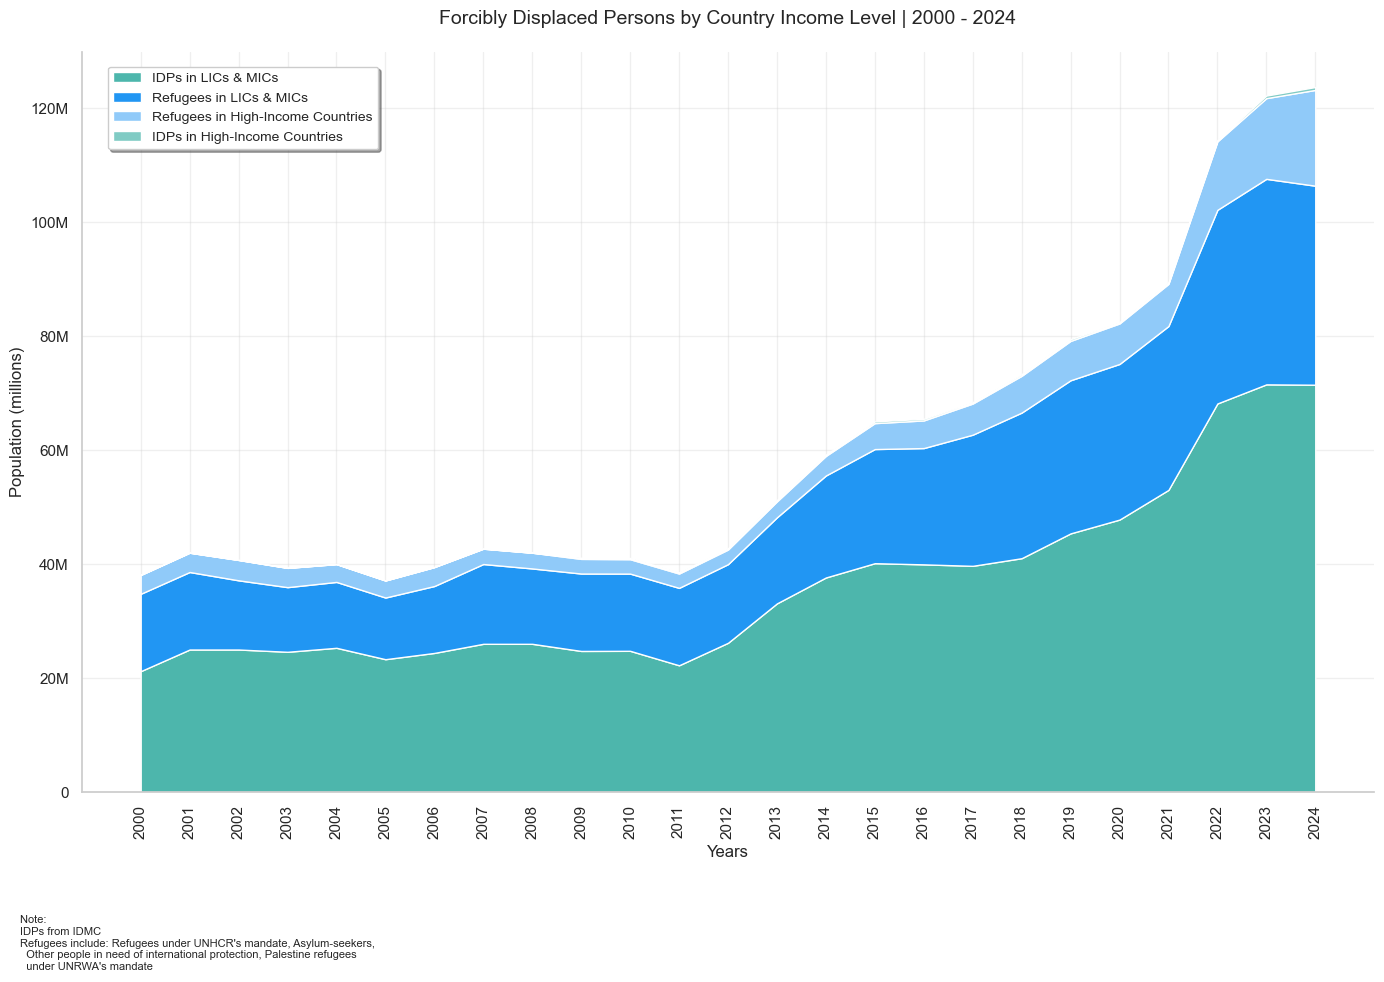

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def process_displacement_data(data_path):
    """
    Process displacement data from the enhanced CSV
    """
    # Read the enhanced dataset
    df = pd.read_csv(data_path)
    
    # Filter from 2000 onwards
    df = df[df['year'] >= 2000]

    # Prepare result data
    result_data = []
    
    for year in sorted(df['year'].unique()):
        year_data = df[df['year'] == year]
        
        # Categorize countries by income level
        lic_mic_data = year_data[
            (year_data['WBG_income_level'] < 4) | 
            (year_data['WBG_income_level'].isna())
        ]
        hic_data = year_data[year_data['WBG_income_level'] >= 4]
        
        # Calculate refugees (sum of refugee-related columns)
        refugee_cols = [
            'refugees_unhcr', 
            'asylum_seekers', 
            'other_protection', 
            'refugees_unrwa'
        ]
        
        # Calculate components
        result_data.append({
            'year': year,
            'lic_mic_idps': lic_mic_data['idps'].sum(),
            'lic_mic_refugees': lic_mic_data[refugee_cols].sum().sum(),
            'hic_idps': hic_data['idps'].sum(),
            'hic_refugees': hic_data[refugee_cols].sum().sum()
        })
    
    # Convert to DataFrame
    return pd.DataFrame(result_data)

def plot_displacement_by_income(data_path, output_path=None):
    """
    Create a stacked area plot of refugees and IDPs by country income level,
    ordered by 2024 values
    """
    # Prepare data
    df = process_displacement_data(data_path)
    
    # Get 2024 values to determine stacking order
    latest_year = df['year'].max()
    latest_values = df[df['year'] == latest_year].iloc[0]
    
    # Create dictionary of values and sort by size
    components = {
        'IDPs in LICs & MICs': latest_values['lic_mic_idps'],
        'Refugees in LICs & MICs': latest_values['lic_mic_refugees'],
        'IDPs in High-Income Countries': latest_values['hic_idps'],
        'Refugees in High-Income Countries': latest_values['hic_refugees']
    }
    
    # Sort components by size (descending)
    ordered_components = dict(
        sorted(components.items(), key=lambda x: x[1], reverse=True)
    )
    
    # Create figure
    plt.figure(figsize=(14, 10))
    
    # Define colors for each component
    color_map = {
        'IDPs in LICs & MICs': '#4DB6AC',
        'Refugees in LICs & MICs': '#2196F3',
        'IDPs in High-Income Countries': '#80CBC4',
        'Refugees in High-Income Countries': '#90CAF9'
    }
    
    # Create mapping between components and their data columns
    data_columns = {
        'IDPs in LICs & MICs': 'lic_mic_idps',
        'Refugees in LICs & MICs': 'lic_mic_refugees',
        'IDPs in High-Income Countries': 'hic_idps',
        'Refugees in High-Income Countries': 'hic_refugees'
    }
    
    # Create stacked area plot in order of 2024 values
    plt.stackplot(df['year'],
                 [df[data_columns[comp]] for comp in ordered_components.keys()],
                 labels=ordered_components.keys(),
                 colors=[color_map[comp] for comp in ordered_components.keys()])
    
    plt.title('Forcibly Displaced Persons by Country Income Level | 2000 - 2024', 
              fontsize=14, pad=20)
    plt.xlabel('Years', fontsize=12)
    plt.ylabel('Population (millions)', fontsize=12)
    
    # Format y-axis with millions/thousands
    plt.gca().yaxis.set_major_formatter(
        plt.FuncFormatter(lambda x, p: f'{int(x/1000000)}M' if x >= 1000000 
                         else f'{int(x/1000):,}k' if x >= 1000 
                         else str(int(x))))
    
    # Set x-axis ticks
    all_years = df['year'].unique()
    plt.xticks(all_years, all_years, rotation=90, ha='center')
    
    # Add grid
    plt.grid(True, alpha=0.3)
    
    # Add legend
    plt.legend(loc='upper left',
              bbox_to_anchor=(0.02, 0.98),
              ncol=1,
              borderaxespad=0,
              frameon=True,
              fancybox=True,
              shadow=True,
              fontsize=10)
    
    # Add explanatory note
    plt.figtext(0.02, 0.02, 
                "Note: \n"
                "IDPs from IDMC\n"
                "Refugees include: Refugees under UNHCR's mandate, Asylum-seekers, \n"
                "  Other people in need of international protection, Palestine refugees \n"
                "  under UNRWA's mandate", 
                fontsize=8, 
                verticalalignment='bottom', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    plt.tight_layout()
    
    # Adjust layout
    plt.subplots_adjust(bottom=0.2)
    
    # Print totals for 2024
    print(f"\nTotals for {latest_year} (ordered by size):")
    for component, value in ordered_components.items():
        print(f"{component}: {value:,.0f}")
    
    # Save figure if output path is provided
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
        
    return plt

# Main execution
if __name__ == "__main__":
    # Specify the path to the enhanced dataset
    data_path = Path('comprehensive_displacement_data.csv')
    
    # Specify output path for saving
    output_path = Path('displacement_plot.png')
    
    # Create and show the plot
    plot = plot_displacement_by_income(data_path, output_path)
    plot.show()

<sub><em>Source: [UNHCR (United Nations High Commissioner for Refugees)](https://www.unhcr.org/data.html) & [IDMC (Internal Displacement Monitoring Centre)](https://www.internal-displacement.org/)</em></sub>


## Top origin/host refugees and IDPs countries 

> ⚠ **Important**  
> THESE NUMBERS ARE UNDER REVISION.

In [15]:
import pandas as pd
import numpy as np

def get_comprehensive_refugee_origins(year=2024):
    """
    Retrieve comprehensive refugee origins, including special cases
    
    Parameters:
    -----------
    year : int, optional
        Year to analyze (default 2022)
    
    Returns:
    --------
    pd.DataFrame
        Top refugee origin countries with comprehensive counting
    """
    # Initialize UNHCR client
    unhcr = UNHCRDataFinder()
    
    # Comprehensive list of known large refugee populations
    special_cases = {
        'Afghanistan': 6_000_000,
        'Syria': 5_600_000,
        'Venezuela': 7_100_000,
        'Palestine': 5_950_000,  # Initial estimate
        'South Sudan': 2_200_000,
        'Myanmar': 1_200_000,
        'Democratic Republic of the Congo': 1_000_000
    }
    
    try:
        # Fetch UNRWA data for Palestine refugees
        unrwa_data = unhcr.get_unrwa_data(year, year)
        unrwa_palestine_refugees = unrwa_data[unrwa_data['year'] == year]['total'].values[0]
        
        # Update Palestine refugees with precise UNRWA data
        special_cases['Palestine'] = unrwa_palestine_refugees
        
        # Fetch population data
        population_data = unhcr.get_population_data(year, year)
        
        # Attempt to fetch demographics
        try:
            demographics = unhcr.get_demographics(year, 
                                                  population_types=['refugees', 'oip'])
        except Exception as e:
            print(f"Error fetching demographics: {e}")
            demographics = pd.DataFrame()
        
        # Prepare refugee data
        refugee_data = []
        
        # Method 1: Use population data if available
        if not population_data.empty:
            total_refugees = population_data['refugees'].values[0]
            print(f"\nTotal global refugees from population data: {total_refugees:,}")
        
        # Method 2: Use demographics total as a reference
        if not demographics.empty:
            total_demographics = demographics['total'].values[0]
            print(f"Total demographics: {total_demographics:,}")
        
        # Create DataFrame from special cases
        refugee_data = [
            {'country': country, 'refugees': refugees} 
            for country, refugees in special_cases.items()
        ]
        
        # Convert to DataFrame
        df = pd.DataFrame(refugee_data)
        
        # Ensure numeric type and sort
        df['refugees'] = pd.to_numeric(df['refugees'], errors='coerce')
        
        # Sort and select top origins
        top_origins = (df
                       .nlargest(15, 'refugees')
                       .reset_index(drop=True))
        
        return top_origins
    
    except Exception as e:
        print(f"Comprehensive error: {e}")
        
        # Final fallback to special cases
        fallback_data = [
            {'country': country, 'refugees': refugees} 
            for country, refugees in special_cases.items()
        ]
        
        return pd.DataFrame(fallback_data)

# Comprehensive analysis function
def display_comprehensive_refugee_analysis(year=2024):
    """
    Display comprehensive refugee origins analysis
    
    Parameters:
    -----------
    year : int, optional
        Year to analyze (default 2022)
    """
    print(f"\nComprehensive Refugee Origins Analysis for {year}")
    print("=" * 50)
    
    # Get comprehensive refugee origins
    top_origins = get_comprehensive_refugee_origins(year)
    
    # Display results
    print("\nTop Refugee Origin Countries:")
    print("=" * 30)
    
    # Use tabulate for nice formatting
    from tabulate import tabulate
    print(tabulate(top_origins, headers='keys', tablefmt='pretty', showindex=False))

# Example usage
if __name__ == "__main__":
    display_comprehensive_refugee_analysis()


Comprehensive Refugee Origins Analysis for 2024

Total global refugees from population data: 31,956,584

Top Refugee Origin Countries:
+----------------------------------+----------+
|             country              | refugees |
+----------------------------------+----------+
|            Venezuela             | 7100000  |
|           Afghanistan            | 6000000  |
|            Palestine             | 5975950  |
|              Syria               | 5600000  |
|           South Sudan            | 2200000  |
|             Myanmar              | 1200000  |
| Democratic Republic of the Congo | 1000000  |
+----------------------------------+----------+


<sub><em>Source: [UNHCR (United Nations High Commissioner for Refugees)](https://www.unhcr.org/data.html)</em></sub>  

# Violence
## Global Organized Crime 
XX.

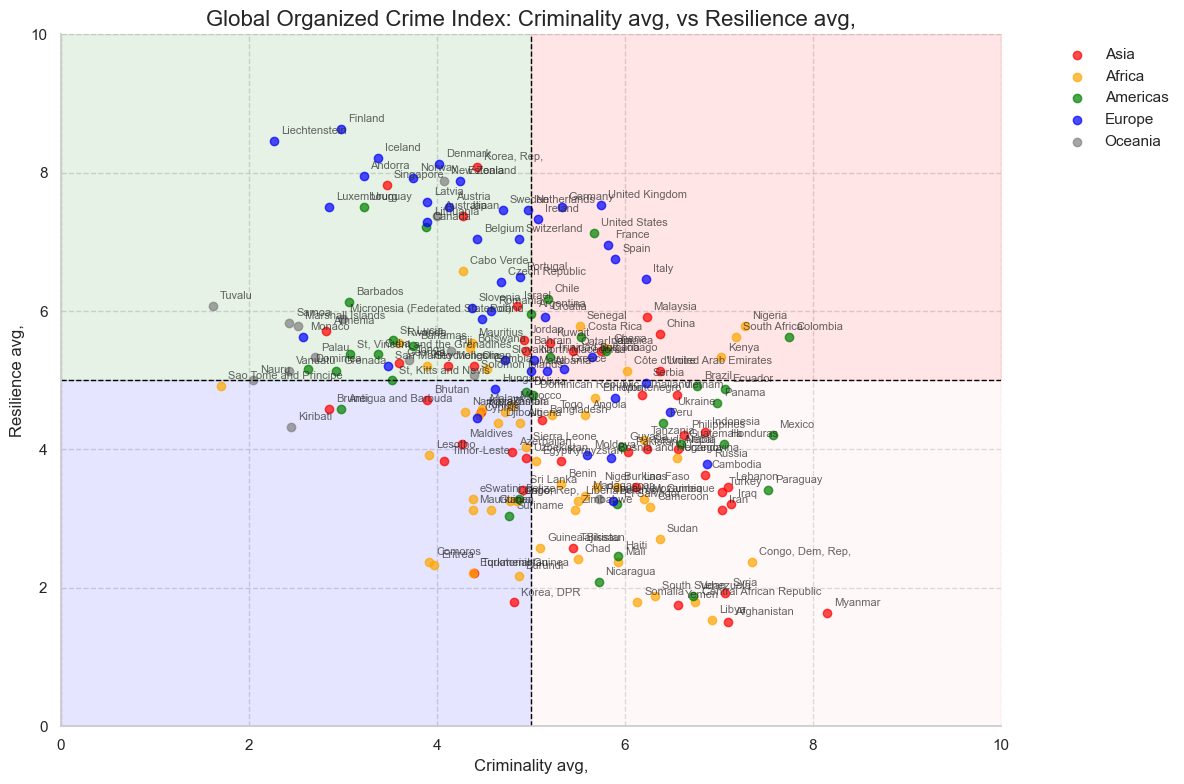

In [2]:
# %%
# jupyter: {'source_hidden': true}
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

def create_interactive_crime_plot(file_path):
    """
    Create an interactive scatter plot with dropdown menus for selecting metrics
    
    Parameters:
    -----------
    file_path : str
        Path to the Excel file containing the dataset
    """
    # Read the Excel file
    df = pd.read_excel(file_path, sheet_name='2023_dataset')
    
    # Get list of numeric columns for dropdowns
    exclude_cols = ['Country', 'Continent', 'Region']
    numeric_cols = [col for col in df.columns if col not in exclude_cols]
    
    # Create dropdown widgets
    x_dropdown = widgets.Dropdown(
        options=numeric_cols,
        value='Criminality avg,',
        description='X-axis:',
        style={'description_width': 'initial'},
        layout={'width': 'auto'}
    )
    
    y_dropdown = widgets.Dropdown(
        options=numeric_cols,
        value='Resilience avg,',
        description='Y-axis:',
        style={'description_width': 'initial'},
        layout={'width': 'auto'}
    )
    
    def plot_scatter(x_metric, y_metric):
        """Create the scatter plot with the selected metrics"""
        plt.figure(figsize=(12, 8))
        
        # Color the quadrants
        plt.axvline(x=5, color='black', linestyle='--', linewidth=1)
        plt.axhline(y=5, color='black', linestyle='--', linewidth=1)
        
        # Fill quadrants with semi-transparent colors
        plt.fill_between([0, 5], 5, 10, color='green', alpha=0.1)  # Top-left
        plt.fill_between([5, 10], 5, 10, color='red', alpha=0.1)   # Top-right
        plt.fill_between([0, 5], 0, 5, color='blue', alpha=0.1)    # Bottom-left
        plt.fill_between([5, 10], 0, 5, color='pink', alpha=0.1)   # Bottom-right
        
        # Color mapping for continents
        continent_colors = {
            'Africa': 'orange',
            'Americas': 'green',
            'Asia': 'red',
            'Europe': 'blue',
            'Oceania': 'gray'
        }
        
        # Create scatter plot
        for continent in df['Continent'].unique():
            subset = df[df['Continent'] == continent]
            plt.scatter(subset[x_metric], subset[y_metric],
                      c=continent_colors[continent],
                      label=continent,
                      alpha=0.7)
        
        # Add country labels
        for _, row in df.iterrows():
            plt.annotate(row['Country'],
                        (row[x_metric], row[y_metric]),
                        xytext=(5, 5),
                        textcoords='offset points',
                        fontsize=8,
                        alpha=0.7)
        
        # Customize the plot
        plt.title(f'Global Organized Crime Index: {x_metric} vs {y_metric}',
                 fontsize=16)
        plt.xlabel(x_metric, fontsize=12)
        plt.ylabel(y_metric, fontsize=12)
        plt.xlim(0, 10)
        plt.ylim(0, 10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()
    
    def update_plot(*args):
        """Callback function to update the plot when dropdowns change"""
        clear_output(wait=True)
        # Display dropdowns
        display(widgets.HBox([x_dropdown, y_dropdown]))
        # Create new plot
        plot_scatter(x_dropdown.value, y_dropdown.value)
    
    # Set up the callback
    x_dropdown.observe(update_plot, 'value')
    y_dropdown.observe(update_plot, 'value')
    
    # Initial plot
    update_plot()

# Example usage
if __name__ == '__main__':
    file_path = os.path.join(data_dir, 'global_oc_index.xlsx')
    create_interactive_crime_plot(file_path)

<sub><em>Source: [Global Criminality Index](https://globalinitiative.net/analysis/global-organized-crime-index-2023/) — Global Initiative Against Transnational Organized Crime, *Global Organized Crime Index 2023*.</em></sub>  

# Demographics
## Projected WB Population
XX.

<Figure size 640x480 with 0 Axes>

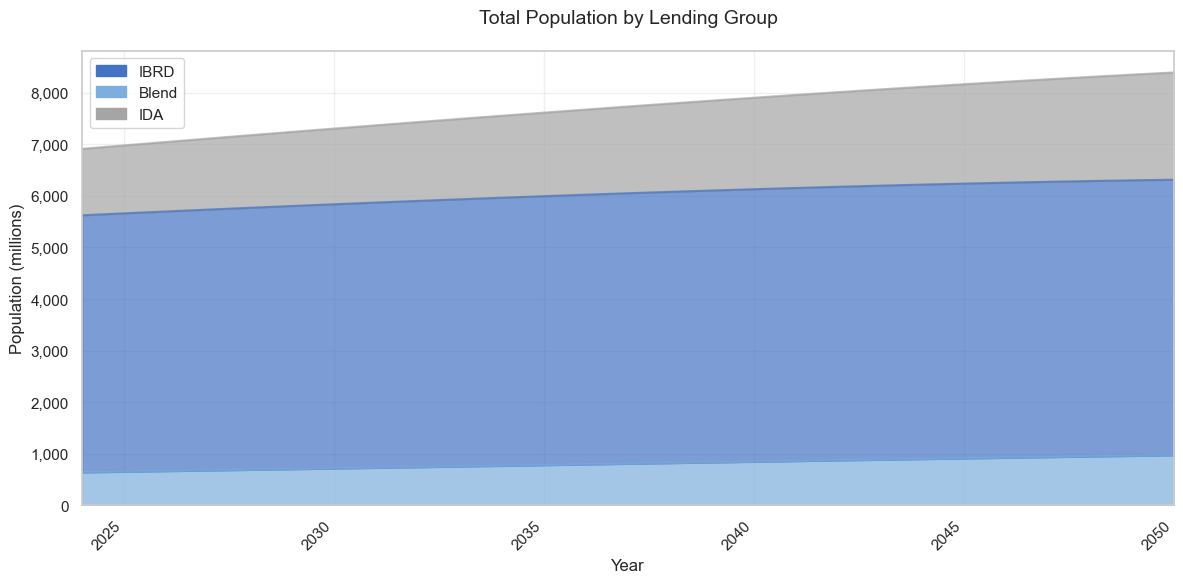

<Figure size 640x480 with 0 Axes>

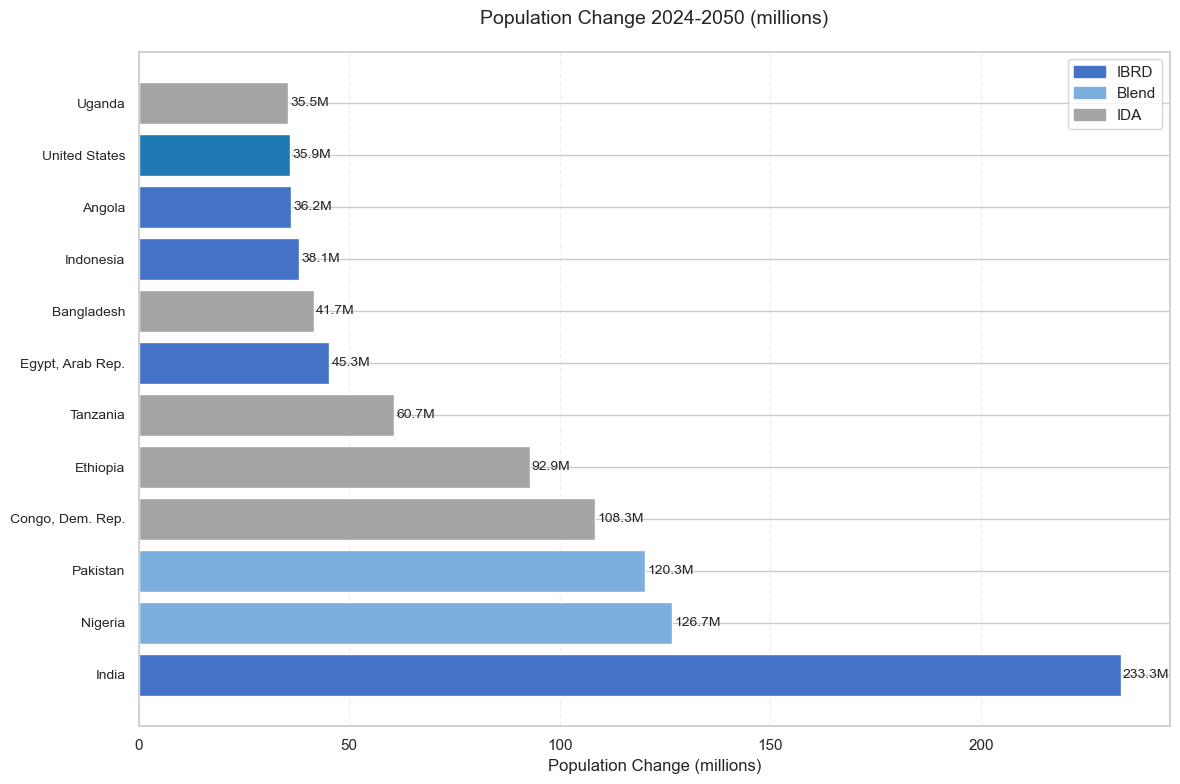

In [34]:
# %%
# jupyter: {'source_hidden': true}
# # Initialize the API client
# api_client = UNPopulationDataPortalAPI()

# # Test API connection
# if not api_client.test_api_connection():
#     logger.error("Unable to establish API connection.")
#     sys.exit(1)

# try:
#     # Retrieve country IDs
#     country_ids = api_client.get_country_ids()
#     logger.info(f"Total Countries Retrieved: {len(country_ids)}")
#     logger.info("First 10 Country IDs: %s", country_ids[:10])

# except Exception as e:
#     logger.error(f"An error occurred: {e}")

def plot_population_trends_by_lending(data_dir, end_year=2050):
    """
    Create stacked area chart of total population by lending group
    """
    # Read data
    file_path = os.path.join(data_dir, 'un_pop_data.xlsx')
    lend_group_path = os.path.join(data_dir, 'lend_group.xlsx')
    
    df = pd.read_excel(file_path, sheet_name='Medium variant')
    lending_df = pd.read_excel(lend_group_path)
    
    # Process data
    df = df.dropna(subset=['ISO3 Alpha-code'])
    df['Total Population, as of 1 January (thousands)'] = pd.to_numeric(
        df['Total Population, as of 1 January (thousands)'], 
        errors='coerce'
    )
    
    # Merge with lending group data
    df = df.merge(lending_df[['Code', 'Lending category', 'Economy']], 
                 left_on='ISO3 Alpha-code', 
                 right_on='Code', 
                 how='left')
    
    # Clear previous plots
    plt.clf()
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Color mapping
    color_map = {
        'IBRD': '#4472C4',     # Royal blue
        'Blend': '#7CAFDD',    # Lighter blue
        'IDA': '#A5A5A5'       # Gray
    }
    
    # Create pivot table for stacked area
    lending_group_pop = df.pivot_table(
        index='Year',
        columns='Lending category',
        values='Total Population, as of 1 January (thousands)',
        aggfunc='sum'
    )
    
    # Filter data up to end_year
    lending_group_pop = lending_group_pop[lending_group_pop.index <= end_year]
    
    # Create stacked area plot
    lending_group_pop.plot(
        kind='area',
        stacked=True,
        ax=ax,
        color=[color_map.get(cat, '#1F77B4') for cat in lending_group_pop.columns],
        alpha=0.7
    )
    
    # Customize plot
    ax.set_xlim(lending_group_pop.index.min(), end_year)
    ax.set_title('Total Population by Lending Group', fontsize=14, pad=20)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Population (millions)', fontsize=12)
    
    # Format y-axis with millions
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000):,}'))
    
    # Rotate x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Add legend
    handles = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
    labels = list(color_map.keys())
    ax.legend(handles, labels, loc='upper left')
    
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_population_change_by_country(data_dir, start_year=2024, top_n=12):
    """
    Create horizontal bar chart of population change by country
    """
    # Read data
    file_path = os.path.join(data_dir, 'un_pop_data.xlsx')
    lend_group_path = os.path.join(data_dir, 'lend_group.xlsx')
    
    df = pd.read_excel(file_path, sheet_name='Medium variant')
    lending_df = pd.read_excel(lend_group_path)
    
    # Process data
    df = df.dropna(subset=['ISO3 Alpha-code'])
    df['Total Population, as of 1 January (thousands)'] = pd.to_numeric(
        df['Total Population, as of 1 January (thousands)'], 
        errors='coerce'
    )
    
    # Merge with lending group data
    df = df.merge(lending_df[['Code', 'Lending category', 'Economy']], 
                 left_on='ISO3 Alpha-code', 
                 right_on='Code', 
                 how='left')
    
    # Calculate population change
    pop_start = df[df['Year'] == start_year].set_index('ISO3 Alpha-code')['Total Population, as of 1 January (thousands)']
    pop_2050 = df[df['Year'] == 2050].set_index('ISO3 Alpha-code')['Total Population, as of 1 January (thousands)']
    pop_change = (pop_2050 - pop_start) / 1000  # Convert to millions
    
    # Add population change to 2050 data
    df_2050 = df[df['Year'] == 2050].copy()
    df_2050['Population Change (millions)'] = df_2050['ISO3 Alpha-code'].map(pop_change)
    
    # Clear previous plots
    plt.clf()
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Color mapping
    color_map = {
        'IBRD': '#4472C4',     # Royal blue
        'Blend': '#7CAFDD',    # Lighter blue
        'IDA': '#A5A5A5'       # Gray
    }
    
    # Get top changes
    top_changes = df_2050.nlargest(top_n, 'Population Change (millions)').sort_values('Population Change (millions)')
    
    # Create horizontal bar chart
    bars = ax.barh(
        range(len(top_changes)),
        top_changes['Population Change (millions)'],
        color=[color_map.get(cat, '#1F77B4') for cat in top_changes['Lending category']]
    )
    
    # Customize plot
    ax.invert_yaxis()
    ax.set_title(f'Population Change {start_year}-2050 (millions)', fontsize=14, pad=20)
    ax.set_xlabel('Population Change (millions)', fontsize=12)
    ax.set_yticks(range(len(top_changes)))
    ax.set_yticklabels(top_changes['Economy'], fontsize=10)
    
    # Add value labels on bars
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.5,                     # x position with offset
                bar.get_y() + bar.get_height()/2, # y position
                f'{width:,.1f}M',                 # text
                ha='left',                        # horizontal alignment
                va='center',                      # vertical alignment
                fontsize=10)                      # font size
    
    # Add legend
    handles = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
    labels = list(color_map.keys())
    ax.legend(handles, labels, loc='upper right')
    
    # Add grid
    ax.grid(True, axis='x', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # Create and display both plots
    plot_population_trends_by_lending(data_dir)
    plot_population_change_by_country(data_dir)

<sub><em>Source: [UN Population Data](https://population.un.org/wpp/) and World Bank</em></sub>

## Millions of Extreme Poor
XX.

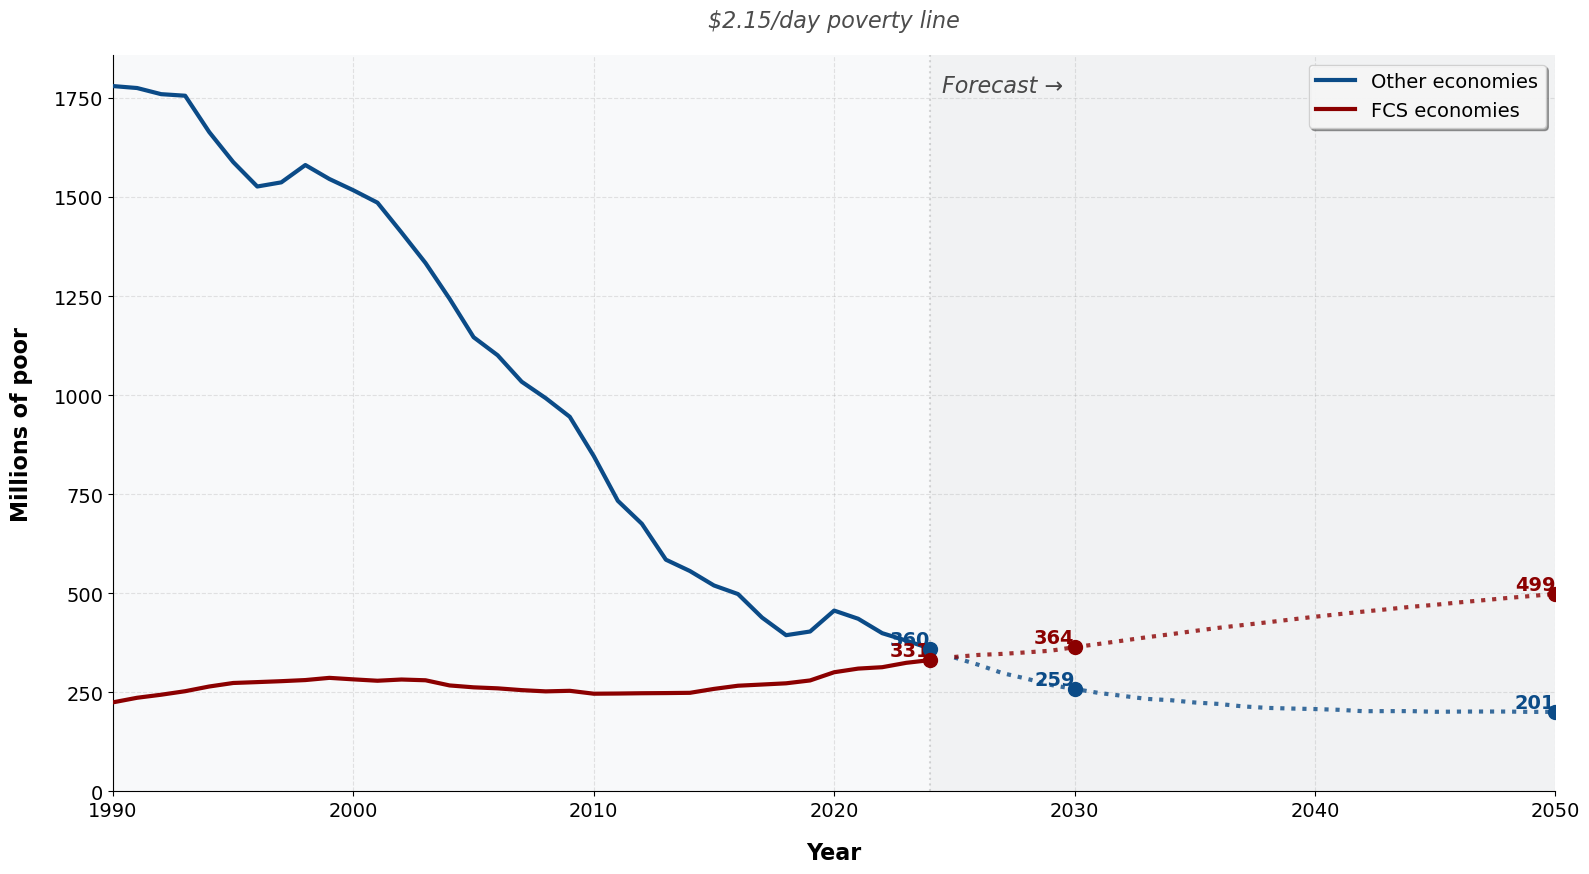

In [16]:
# Define FCS countries
FCS_COUNTRIES = [
    'Afghanistan', 'Burkina Faso', 'Cameroon', 'Central African Republic', 
    'Congo, Dem. Rep.', 'Ethiopia', 'Haiti', 'Iraq', 'Lebanon', 'Mali', 
    'Mozambique', 'Myanmar', 'Niger', 'Nigeria', 'Somalia', 'South Sudan',
    'Sudan', 'Syrian Arab Republic', 'Ukraine', 'West Bank and Gaza',
    'Yemen, Rep.', 'Burundi', 'Chad', 'Comoros', 'Congo, Rep.', 'Eritrea',
    'Guinea-Bissau', 'Kiribati', 'Kosovo', 'Libya', 'Marshall Islands',
    'Micronesia, Fed. Sts.', 'Papua New Guinea', 'São Tomé and Principe',
    'Solomon Islands', 'Timor-Leste', 'Tuvalu', 'Venezuela, RB', 'Zimbabwe'
]

def plot_poverty_trends(data_dir: str, output_path: str = None) -> None:
    """
    Create an enhanced plot showing poverty trends for FCS and other economies,
    with historical data and forecasts up to 2050.
    """
    import os
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    # Read the data
    pip_path = os.path.join(data_dir, 'pip_forecast_2050.csv')
    df = pd.read_csv(pip_path)
    
    # Filter for $2.15 poverty line
    df = df[df['povertyline'] == 2.15].copy()
    
    # Create FCV grouping based on country list
    df['is_fcv'] = df['country'].isin(FCS_COUNTRIES).astype(int)
    
    # Aggregate poorpop by year and FCV status
    agg_df = df.groupby(['year', 'is_fcv'])['poorpop'].sum().reset_index()
    
    # Pivot the data for plotting
    plot_df = agg_df.pivot(index='year', columns='is_fcv', values='poorpop')
    plot_df.columns = ['Other economies', 'FCS economies']
    
    # Create plot
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.set_facecolor('#F8F9FA')
    fig.patch.set_facecolor('white')
    
    # Define colors
    colors = ['#0B4B87', '#8B0000']  # Dark blue for others, Dark red for FCS
    
    # Historical data (up to 2024)
    historical = plot_df[plot_df.index <= 2024]
    forecast = plot_df[plot_df.index > 2024]
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.2, color='gray', zorder=0)
    
    # Plot historical data (solid lines)
    for i, col in enumerate(plot_df.columns):
        ax.plot(historical.index, historical[col], 
               label=col, 
               linewidth=3.0,  # Increased line width
               color=colors[i],
               zorder=3)
    
    # Plot forecast data (dashed lines)
    for i, col in enumerate(plot_df.columns):
        ax.plot(forecast.index, forecast[col], 
               linestyle=':', 
               linewidth=3.0,  # Increased line width
               color=colors[i],
               alpha=0.8,
               zorder=3)
        
        # Add data points for key years
        for year in [2024, 2030, 2050]:
            if year in plot_df.index:
                ax.scatter(year, plot_df.loc[year, col], 
                          color=colors[i], s=100,  # Increased point size
                          zorder=4)
    
    # Customize axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize=14)  # Increased tick label size
    
    # Add labels
    ax.set_xlabel('Year', fontsize=16, fontweight='bold', labelpad=15)  # Increased font size
    ax.set_ylabel('Millions of poor', fontsize=16, fontweight='bold', labelpad=15)  # Increased font size
    
    # Set axis limits
    ax.set_ylim(bottom=0)
    ax.set_xlim(1990, 2050)
    
    # Add title and subtitle
    plt.suptitle('', 
                 fontsize=20, fontweight='bold', y=0.95)  # Increased title size
    plt.title('$2.15/day poverty line',
             fontsize=16, style='italic', alpha=0.7, pad=20)  # Increased subtitle size
    
    # Add legend inside the plot with larger text
    legend = ax.legend(ncol=1, loc='upper right',
                      frameon=True, fancybox=True, shadow=True,
                      fontsize=14)  # Increased legend font size
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.9)
    
    # Add forecast annotation with larger text
    ax.axvline(x=2024, color='gray', linestyle=':', alpha=0.3, zorder=2)
    ax.text(2024.5, ax.get_ylim()[1]*0.95, 'Forecast →', 
            fontsize=16, alpha=0.7,  # Increased annotation size
            style='italic')
    
    # Add shaded forecast area
    forecast_shade = patches.Rectangle((2024, 0), 26, ax.get_ylim()[1],
                                     facecolor='gray', alpha=0.05,
                                     zorder=1)
    ax.add_patch(forecast_shade)
    
    # Add data labels for key years with larger text
    for i, col in enumerate(plot_df.columns):
        for year in [2024, 2030, 2050]:
            if year in plot_df.index:
                value = plot_df.loc[year, col]
                ax.text(year, value, f'{value:.0f}', 
                       color=colors[i], fontweight='bold',
                       fontsize=14,  # Increased label size
                       ha='right', va='bottom')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save or display
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()
    
    plt.close()

plot_poverty_trends(data_dir)

<sub><em>Source: [Poverty, Prosperity and Planet Report 2024](https://www.worldbank.org/en/publication/poverty-prosperity-and-planet)</em></sub>  

## Millions of poor, by poverty line, in FCS and non-FCS
XX.

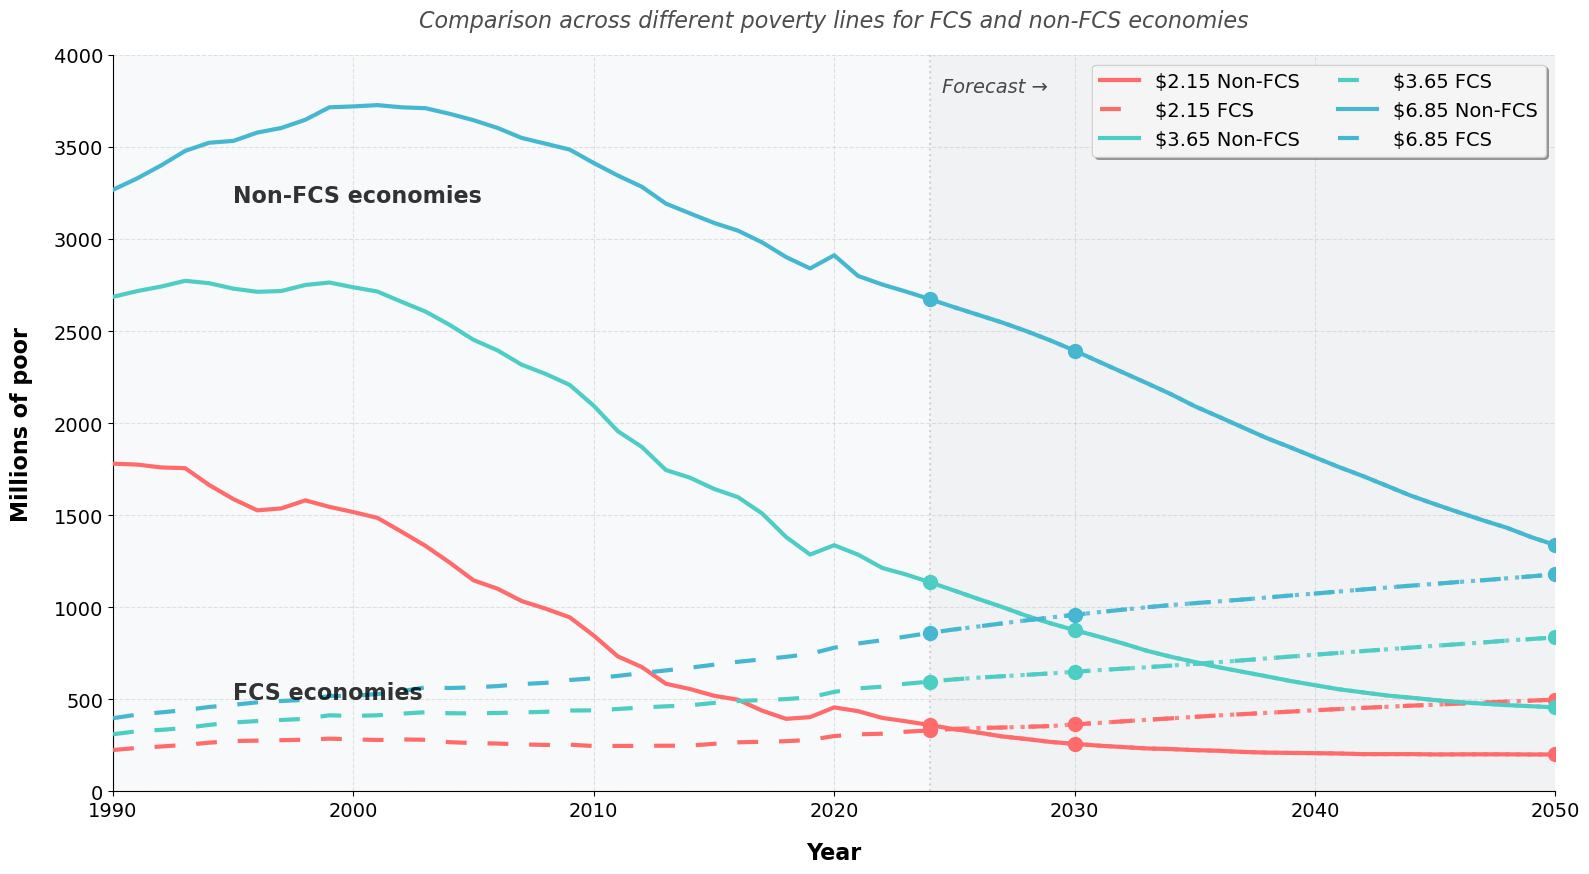

In [28]:
def plot_poverty_trends_all(data_dir: str, output_path: str = None) -> None:
    """
    Create an enhanced plot showing poverty trends for FCS and non-FCS economies 
    across all poverty lines, with historical data and forecasts up to 2050.
    """
    import os
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    # Read the data
    pip_path = os.path.join(data_dir, 'pip_forecast_2050.csv')
    df = pd.read_csv(pip_path)
    
    # Create FCV grouping based on country list
    df['is_fcv'] = df['country'].isin(FCS_COUNTRIES).astype(int)
    
    # Create plot
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.set_facecolor('#F8F9FA')
    fig.patch.set_facecolor('white')
    
    # Define colors
    colors = {
        2.15: '#FF6B6B',
        3.65: '#4ECDC4',
        6.85: '#45B7D1'
    }
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.2, color='gray', zorder=0)
    
    # Process each poverty line
    for pline in [2.15, 3.65, 6.85]:
        df_pline = df[df['povertyline'] == pline].copy()
        agg_df = df_pline.groupby(['year', 'is_fcv'])['poorpop'].sum().reset_index()
        
        # Plot for non-FCS
        non_fcs = agg_df[agg_df['is_fcv'] == 0]
        ax.plot(non_fcs['year'], non_fcs['poorpop'], 
                color=colors[pline], 
                label=f'${pline:.2f} Non-FCS',
                linewidth=3.0,  # Increased line width
                zorder=3)
        
        # Plot for FCS
        fcs = agg_df[agg_df['is_fcv'] == 1]
        ax.plot(fcs['year'], fcs['poorpop'], 
                color=colors[pline],
                linestyle=(0, (5, 5)),
                label=f'${pline:.2f} FCS',
                linewidth=3.0,  # Increased line width
                zorder=3)
        
        # Add forecast parts
        non_fcs_forecast = non_fcs[non_fcs['year'] > 2024]
        fcs_forecast = fcs[fcs['year'] > 2024]
        
        ax.plot(non_fcs_forecast['year'], non_fcs_forecast['poorpop'],
                color=colors[pline], linestyle=':', linewidth=3.0, alpha=0.8, zorder=3)
        ax.plot(fcs_forecast['year'], fcs_forecast['poorpop'],
                color=colors[pline], linestyle=':', linewidth=3.0, alpha=0.8, zorder=3)
        
        # Add data points for 2024 and 2030
        for year in [2024, 2030, 2050]:
            if year in non_fcs['year'].values:
                ax.scatter(year, non_fcs[non_fcs['year'] == year]['poorpop'].values[0], 
                          color=colors[pline], s=100, zorder=4)  # Increased point size
                ax.scatter(year, fcs[fcs['year'] == year]['poorpop'].values[0], 
                          color=colors[pline], s=100, zorder=4)  # Increased point size
    
    # Customize axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize=14)  # Increased tick label size
    
    # Add labels
    ax.set_xlabel('Year', fontsize=16, fontweight='bold', labelpad=15)  # Increased font size
    ax.set_ylabel('Millions of poor', fontsize=16, fontweight='bold', labelpad=15)  # Increased font size
    
    # Set axis limits
    ax.set_ylim(bottom=0, top=4000)
    ax.set_xlim(1990, 2050)
    
    # Add title and subtitle
    plt.suptitle('', 
                 fontsize=20, fontweight='bold', y=0.95)  # Increased title size
    plt.title('Comparison across different poverty lines for FCS and non-FCS economies',
             fontsize=16, style='italic', alpha=0.7, pad=20)  # Increased subtitle size
    
    # Create legend with larger text
    legend = ax.legend(ncol=2, loc='upper right',
                      frameon=True, fancybox=True, shadow=True,
                      fontsize=14)  # Increased legend font size
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.9)
    
    # Add forecast annotation with larger text
    ax.axvline(x=2024, color='gray', linestyle=':', alpha=0.3, zorder=2)
    ax.text(2024.5, 3800, 'Forecast →', 
            fontsize=14, alpha=0.7,  # Increased annotation size
            style='italic')
    
    # Add shaded forecast area
    forecast_shade = patches.Rectangle((2024, 0), 26, 4000,
                                     facecolor='gray', alpha=0.05,
                                     zorder=1)
    ax.add_patch(forecast_shade)
    
    # Add annotations for key groups with larger text
    ax.text(1995, 3200, 'Non-FCS economies', 
            fontsize=16, fontweight='bold', alpha=0.8)  # Increased text size
    ax.text(1995, 500, 'FCS economies', 
            fontsize=16, fontweight='bold', alpha=0.8)  # Increased text size
    
    # Adjust layout
    plt.tight_layout()
    
    # Save or display with higher DPI
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()
    
    plt.close()


plot_poverty_trends_all(data_dir)

<sub><em>Source: [Poverty, Prosperity and Planet Report 2024](https://www.worldbank.org/en/publication/poverty-prosperity-and-planet)</em></sub>  

## Millions of poor, by poverty line, in FCS and non-FCS (Bars)

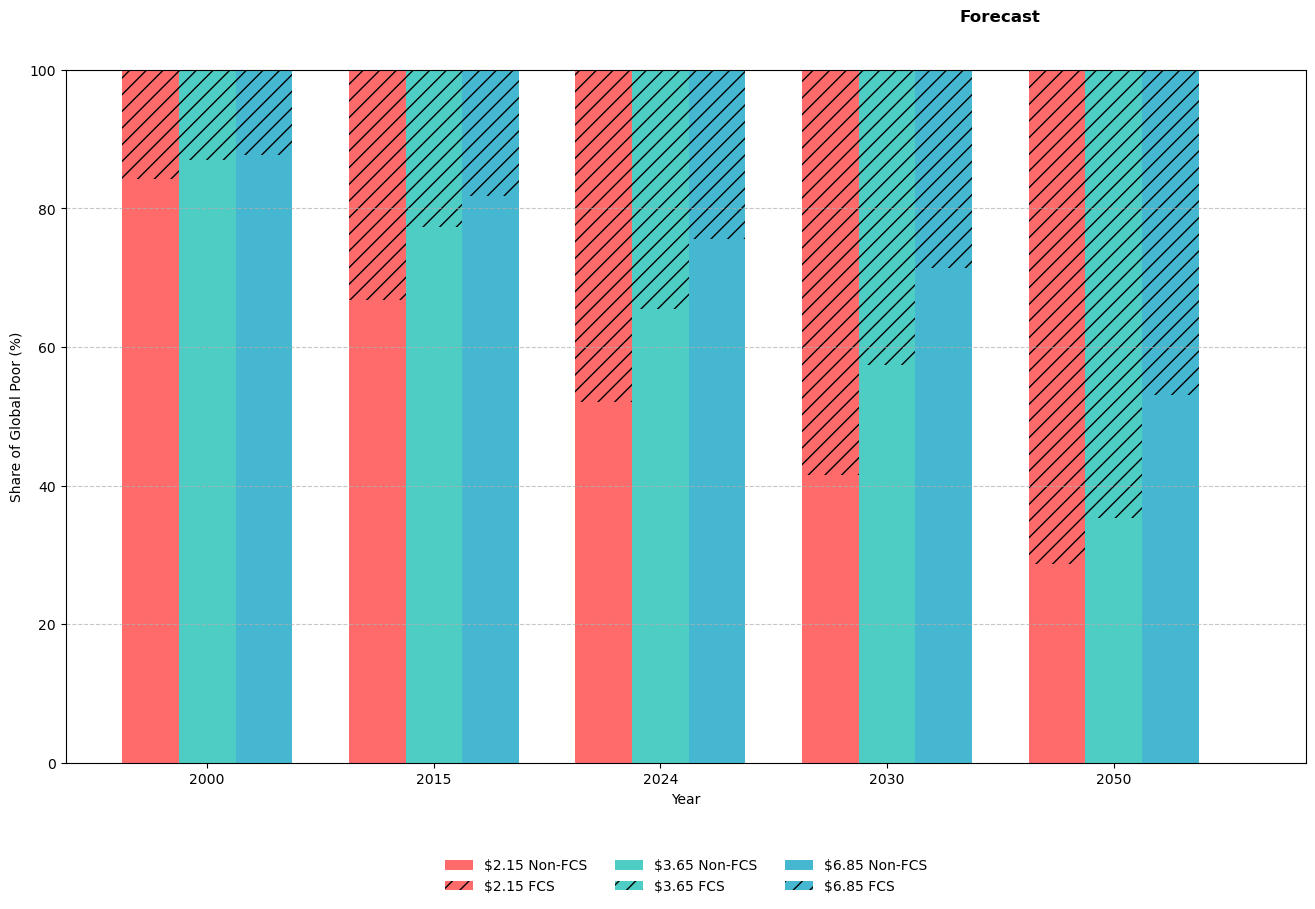

In [59]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_poverty_share_bars(data_dir: str):
    pip_path = os.path.join(data_dir, 'pip_forecast_2050.csv')
    df = pd.read_csv(pip_path)

    # Normalize column names
    df.columns = df.columns.str.strip().str.lower()
    
    # Convert year and povertyline to numeric
    df['povertyline'] = pd.to_numeric(df['povertyline'], errors='coerce')
    df['year'] = pd.to_numeric(df['year'], errors='coerce')

    # Use ISO3 codes instead of country names
    fcs_iso3_codes = [
        'AFG', 'BFA', 'CMR', 'CAF', 'COD', 'ETH', 'HTI', 'IRQ', 'LBN', 'MLI',
        'MOZ', 'MMR', 'NER', 'NGA', 'SOM', 'SSD', 'SDN', 'SYR', 'UKR', 'PSE',
        'YEM', 'BDI', 'TCD', 'COM', 'COG', 'ERI', 'GNB', 'KIR', 'XKX', 'LBY',
        'MHL', 'FSM', 'PNG', 'STP', 'SLB', 'TLS', 'TUV', 'VEN', 'ZWE'
    ]

    # Ensure 'code' column exists and use it for FCS classification
    if 'code' not in df.columns:
        raise KeyError("Column 'code' not found in dataset. Ensure you use ISO3 country codes.")
    
    df['is_fcv'] = df['code'].isin(fcs_iso3_codes).astype(int)

    # Ensure required columns exist
    required_cols = ['pop', 'poorpop']
    for col in required_cols:
        if col not in df.columns:
            raise KeyError(f"Missing required column: {col}")

    key_years = [2000, 2015, 2024, 2030, 2050]
    poverty_lines = [2.15, 3.65, 6.85]

    plot_data = []
    for year in key_years:
        for pline in poverty_lines:
            year_pline_data = df[(df['year'] == year) & (df['povertyline'] == pline)]

            if year_pline_data.empty:
                print(f"Skipping {year}, poverty line {pline}: No data found")
                continue

            # Compute total poor population globally
            total_poor_global = year_pline_data['poorpop'].sum()

            # Compute total poor population for FCS and non-FCS
            total_poor_fcs = year_pline_data[year_pline_data['is_fcv'] == 1]['poorpop'].sum()
            total_poor_non_fcs = year_pline_data[year_pline_data['is_fcv'] == 0]['poorpop'].sum()

            # Avoid division by zero
            fcs_share = (total_poor_fcs / total_poor_global * 100) if total_poor_global > 0 else np.nan
            non_fcs_share = (total_poor_non_fcs / total_poor_global * 100) if total_poor_global > 0 else np.nan

            plot_data.append({
                'year': year,
                'povertyline': pline,
                'non_fcs_share': non_fcs_share,
                'fcs_share': fcs_share
            })

    plot_df = pd.DataFrame(plot_data)

    # If no data, exit early
    if plot_df.empty:
        print("No valid data available for plotting. Exiting.")
        return

    # Plot setup
    plt.figure(figsize=(16, 9))
    colors = {2.15: '#FF6B6B', 3.65: '#4ECDC4', 6.85: '#45B7D1'}
    x = np.arange(len(key_years))
    width = 0.25  # Narrower bars to fit three per year

    # Offsets for the three poverty lines
    offsets = {-1: 2.15, 0: 3.65, 1: 6.85}

    for i, offset in offsets.items():
        fcs_data = plot_df[plot_df['povertyline'] == offset]['fcs_share']
        non_fcs_data = plot_df[plot_df['povertyline'] == offset]['non_fcs_share']

        plt.bar(x + (i * width), non_fcs_data, width, label=f'${offset:.2f} Non-FCS', color=colors[offset])
        plt.bar(x + (i * width), fcs_data, width, bottom=non_fcs_data, label=f'${offset:.2f} FCS', color=colors[offset], hatch='//')

    # Add forecast bracket (covering 2030-2050)
    forecast_start_idx = key_years.index(2030)  # First forecasted year
    forecast_end_idx = key_years.index(2050)    # Last forecasted year
    plt.plot([forecast_start_idx - 0.6, forecast_end_idx + 0.6], [105, 105], color='black', linewidth=1.5)  # Top line
    plt.plot([forecast_start_idx - 0.6, forecast_start_idx - 0.6], [102, 105], color='black', linewidth=1.5)  # Left vertical
    plt.plot([forecast_end_idx + 0.6, forecast_end_idx + 0.6], [102, 105], color='black', linewidth=1.5)  # Right vertical
    plt.text((forecast_start_idx + forecast_end_idx) / 2, 107, "Forecast", ha='center', fontsize=12, fontweight='bold')

    plt.xlabel('Year')
    plt.ylabel('Share of Global Poor (%)')
    plt.title('')
    plt.xticks(x, key_years)

    # Adjust legend to have 3 columns
    plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.12), frameon=False)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, 100)  # Ensures bars always add up to 100%
    plt.show()


plot_poverty_share_bars(data_dir)


<sub><em>Source: [Poverty, Prosperity and Planet Report 2024](https://www.worldbank.org/en/publication/poverty-prosperity-and-planet)</em></sub>  

# Development Indicators and FCV
## Mortality rate, under 5 (per 1,000 live births)
XX.

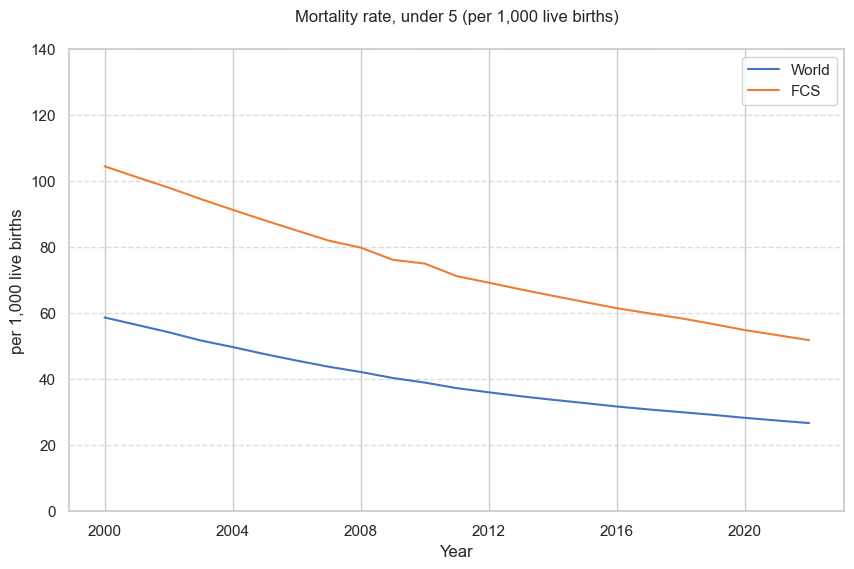

In [ ]:
# %%
# jupyter: {'source_hidden': true}
def get_country_averages(wb_data, countries=None):
    """Helper function to calculate averages for a group of countries"""
    df = pd.DataFrame(wb_data)
    if countries:
        df = df[df['country'].isin(countries)]
    return df.groupby('date')['SH.DYN.MORT'].mean()

def plot_mortality_rate(wb_data):
    """
    Plot under-5 mortality rate
    Indicator: SH.DYN.MORT
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Reshape data for plotting
    df = pd.DataFrame(wb_data)
    
    # Calculate world average (using all countries)
    world_data = get_country_averages(wb_data)
    
    # Calculate FCS average
    fcs_data = get_country_averages(wb_data, FCS_COUNTRIES)
    
    # Plot
    ax.plot(world_data.index, world_data.values, color='#4472C4', label='World')
    ax.plot(fcs_data.index, fcs_data.values, color='#ED7D31', label='FCS')
    
    # Customize
    ax.set_title('Mortality rate, under 5 (per 1,000 live births)', pad=20)
    ax.set_xlabel('Year')
    ax.set_ylabel('per 1,000 live births')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax.legend()
    
    # Adjust y-axis range
    ax.set_ylim(0, 140)
    
    return fig


mortality_data = wb.get_indicator_data(indicator='SH.DYN.MORT', start_year=2000, end_year=2024)
fig = plot_mortality_rate(mortality_data)
plt.show()

<sub><em>Source: [World Bank Development Indicators](https://databank.worldbank.org/source/world-development-indicators)</em></sub>  

## Primary completion rate, total (% of relevant age group)
XX.

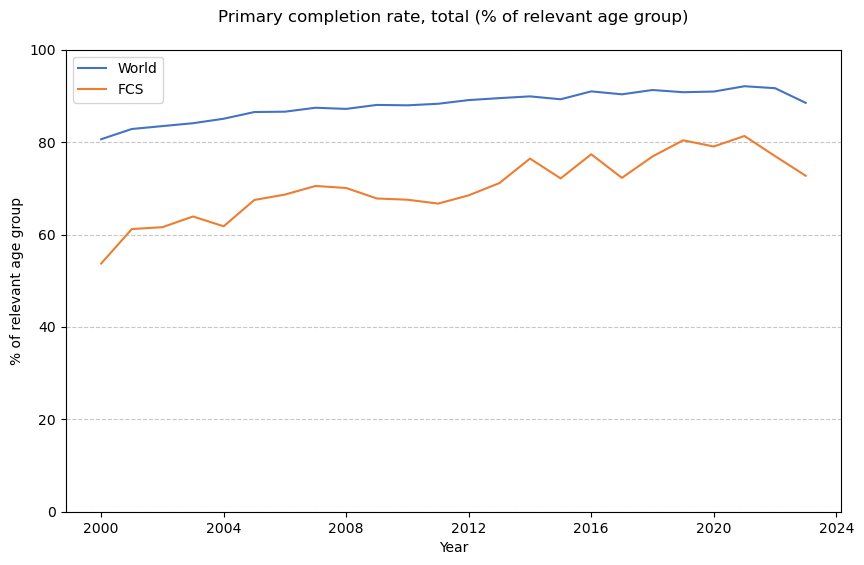

In [10]:
# %%
# jupyter: {'source_hidden': true}
def plot_primary_completion(wb_data):
    """
    Plot primary completion rate
    Indicator: SE.PRM.CMPT.ZS
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Reshape data
    df = pd.DataFrame(wb_data)
    
    # Calculate averages
    world_data = df.groupby('date')['SE.PRM.CMPT.ZS'].mean()
    fcs_data = df[df['country'].isin(FCS_COUNTRIES)].groupby('date')['SE.PRM.CMPT.ZS'].mean()
    
    # Plot
    ax.plot(world_data.index, world_data.values, color='#4472C4', label='World')
    ax.plot(fcs_data.index, fcs_data.values, color='#ED7D31', label='FCS')
    
    # Customize
    ax.set_title('Primary completion rate, total (% of relevant age group)', pad=20)
    ax.set_xlabel('Year')
    ax.set_ylabel('% of relevant age group')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax.legend()
    ax.set_ylim(0, 100)
    
    return fig

# Get data and plot
primary_data = wb.get_indicator_data(indicator='SE.PRM.CMPT.ZS', start_year=2000, end_year=2024)
fig = plot_primary_completion(primary_data)
plt.show()

<sub><em>Source: [World Bank Development Indicators](https://databank.worldbank.org/source/world-development-indicators)</em></sub>  

## People using at least basic sanitation services (% of population)
XX.

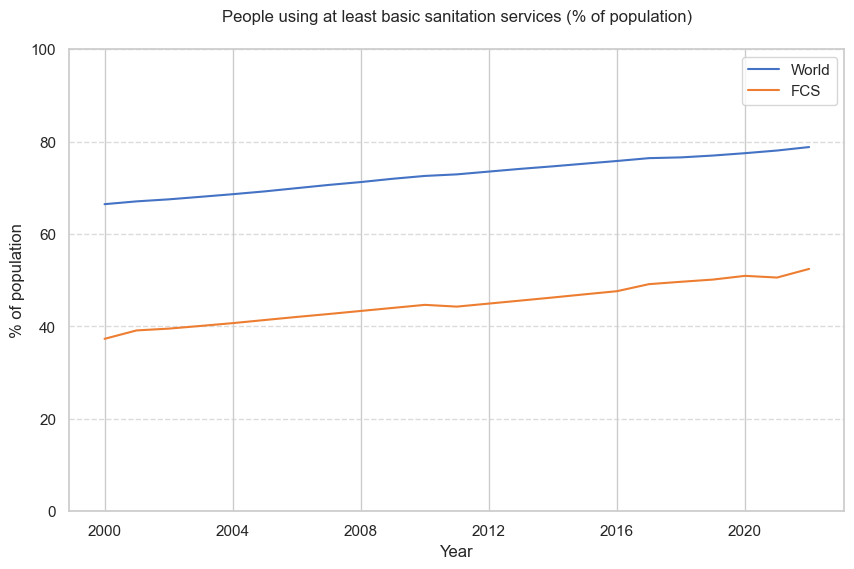

In [11]:
# %%
# jupyter: {'source_hidden': true}
def plot_sanitation(wb_data):
    """
    Plot basic sanitation services
    Indicator: SH.STA.BASS.ZS
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Reshape data
    df = pd.DataFrame(wb_data)
    
    # Calculate averages
    world_data = df.groupby('date')['SH.STA.BASS.ZS'].mean()
    fcs_data = df[df['country'].isin(FCS_COUNTRIES)].groupby('date')['SH.STA.BASS.ZS'].mean()
    
    # Plot
    ax.plot(world_data.index, world_data.values, color='#4472C4', label='World')
    ax.plot(fcs_data.index, fcs_data.values, color='#ED7D31', label='FCS')
    
    # Customize
    ax.set_title('People using at least basic sanitation services (% of population)', pad=20)
    ax.set_xlabel('Year')
    ax.set_ylabel('% of population')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax.legend()
    ax.set_ylim(0, 100)
    
    return fig

# Get data and plot
sanitation_data = wb.get_indicator_data(indicator='SH.STA.BASS.ZS', start_year=2000, end_year=2024)
fig = plot_sanitation(sanitation_data)
plt.show()

<sub><em>Source: [World Bank Development Indicators](https://databank.worldbank.org/source/world-development-indicators)</em></sub>  

## People using at least basic drinking water services (% of population)
XX. 

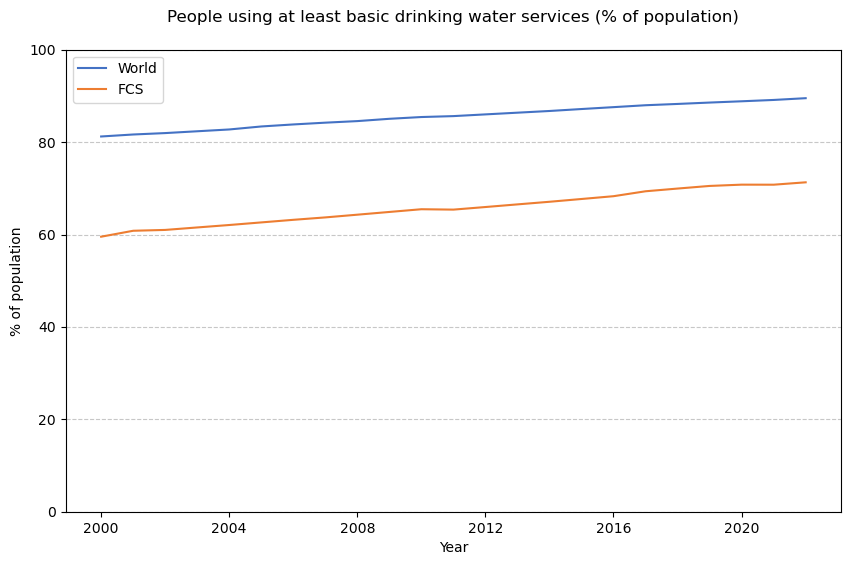

In [11]:
# %%
# jupyter: {'source_hidden': true}
def plot_water_services(wb_data):
    """
    Plot basic drinking water services
    Indicator: SH.H2O.BASW.ZS
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Reshape data
    df = pd.DataFrame(wb_data)
    
    # Calculate averages
    world_data = df.groupby('date')['SH.H2O.BASW.ZS'].mean()
    fcs_data = df[df['country'].isin(FCS_COUNTRIES)].groupby('date')['SH.H2O.BASW.ZS'].mean()
    
    # Plot
    ax.plot(world_data.index, world_data.values, color='#4472C4', label='World')
    ax.plot(fcs_data.index, fcs_data.values, color='#ED7D31', label='FCS')
    
    # Customize
    ax.set_title('People using at least basic drinking water services (% of population)', pad=20)
    ax.set_xlabel('Year')
    ax.set_ylabel('% of population')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax.legend()
    ax.set_ylim(0, 100)
    
    return fig

# Get data and plot
water_data = wb.get_indicator_data(indicator='SH.H2O.BASW.ZS', start_year=2000, end_year=2024)
fig = plot_water_services(water_data)
plt.show()

<sub><em>Source: [World Bank Development Indicators](https://databank.worldbank.org/source/world-development-indicators)</em></sub>  

# Fragility
## States of Fragility 2022
XX.

In [10]:
import os
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio

def create_interactive_fragility_plot(file_path, save_html=True):
    # Read the Excel file
    df = pd.read_excel(file_path, sheet_name='Scores')
    
    # Clean column names by removing 'PC1'
    df.columns = [col.replace('.PC1', '') for col in df.columns]
    
    # Create static figure using plotly express for notebook display
    static_fig = px.scatter(df, 
                          x='Aggregate', 
                          y='Political',
                          color='type',
                          color_discrete_map={
                              'Extremely fragile': 'red',
                              'Other fragile': 'orange',
                              'Rest of the world': 'gray'
                          },
                          hover_data=['country'],
                          title='States of Fragility 2022: Aggregate vs Political (Static Version)')
    
    # Create interactive figure with dropdowns
    interactive_fig = go.Figure()
    
    # Get list of numeric columns for dropdowns
    exclude_cols = ['iso3c', 'country', 'type']
    numeric_cols = [col for col in df.columns if col not in exclude_cols]
    
    # Add scatter trace
    interactive_fig.add_trace(go.Scatter(
        x=df['Aggregate'], 
        y=df['Political'],
        mode='markers',
        text=df['country'],
        hoverinfo='text+x+y',
        marker=dict(
            color=df['type'].map({
                'Extremely fragile': 'red',
                'Other fragile': 'orange',
                'Rest of the world': 'gray'
            }),
            size=10,
            opacity=0.7
        )
    ))

    # Update layout for interactive figure
    interactive_fig.update_layout(
        title='States of Fragility 2022: Aggregate vs Political (Interactive Version)',
        xaxis_title='Aggregate',
        yaxis_title='Political',
        height=600,
        width=1000,
        updatemenus=[
            # X-axis dropdown
            dict(
                buttons=list([
                    dict(
                        args=[{'x': [df[col]]}],
                        label=col,
                        method='restyle'
                    ) for col in numeric_cols
                ]),
                direction="down",
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0.1,
                xanchor="left",
                y=1.1,
                yanchor="top"
            ),
            # Y-axis dropdown
            dict(
                buttons=list([
                    dict(
                        args=[{'y': [df[col]]}],
                        label=col,
                        method='restyle'
                    ) for col in numeric_cols
                ]),
                direction="down",
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0.3,
                xanchor="left",
                y=1.1,
                yanchor="top"
            )
        ],
        annotations=[
            dict(text="X-axis:", x=0, xref="paper", y=1.15, yref="paper", align="left", showarrow=False),
            dict(text="Y-axis:", x=0.2, xref="paper", y=1.15, yref="paper", align="left", showarrow=False)
        ]
    )
    
    # Save interactive version to HTML in _build/html directory
    if save_html:
        # Create _build/html directory if it doesn't exist
        build_dir = os.path.join('_build', 'html')
        os.makedirs(build_dir, exist_ok=True)
        
        # Save the file
        html_filename = 'interactive_fragility_plot.html'
        html_path = os.path.join(build_dir, html_filename)
        interactive_fig.write_html(html_path)
    
    return static_fig, interactive_fig

file_path = os.path.join(data_dir, 'sof_2022.xlsx')
static_fig, _ = create_interactive_fragility_plot(file_path)
static_fig.show()  # This will show the static version in the notebook


[Click here for interactive version](interactive_fragility_plot.html)

<sub><em>Source: [OECD States of Fragility 2022](https://www.oecd.org/dac/states-of-fragility-2022-bc0ab39e-en.htm)</em></sub>  

# Maps
## FCS Map - FY25
XX.

In [9]:
import os
import plotly.express as px
import pandas as pd

def create_fcs_classification_map(save_html=True):
    """
    Create choropleth maps visualizing Fragile and Conflict-Affected Situations (FCS) classification.
    Saves interactive version in both _build/html and docs/notebooks directories.
    """
    # Expanded country list including Greenland
    all_countries = [
        "Afghanistan", "Albania", "Algeria", "Andorra", "Angola", "Antigua and Barbuda",
        "Argentina", "Armenia", "Australia", "Austria", "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh",
        "Barbados", "Belarus", "Belgium", "Belize", "Benin", "Bhutan", "Bolivia", "Bosnia and Herzegovina",
        "Botswana", "Brazil", "Brunei", "Bulgaria", "Burkina Faso", "Burundi", "Cabo Verde", "Cambodia",
        "Cameroon", "Canada", "Central African Republic", "Chad", "Chile", "China", "Colombia", "Comoros",
        "Congo, Dem. Rep.", "Congo, Rep.", "Costa Rica", "Cote d'Ivoire", "Croatia", "Cuba", "Cyprus",
        "Czech Republic", "Denmark", "Djibouti", "Dominica", "Dominican Republic", "Ecuador", "Egypt",
        "El Salvador", "Equatorial Guinea", "Eritrea", "Estonia", "Eswatini", "Ethiopia", "Fiji", "Finland",
        "France", "Gabon", "Gambia", "Georgia", "Germany", "Ghana", "Greece", "Grenada", "Guatemala",
        "Guinea", "Guinea-Bissau", "Guyana", "Haiti", "Honduras", "Hungary", "Iceland", "India", "Indonesia",
        "Iran", "Iraq", "Ireland", "Israel", "Italy", "Jamaica", "Japan", "Jordan", "Kazakhstan", "Kenya",
        "Kiribati", "Kuwait", "Kyrgyzstan", "Laos", "Latvia", "Lebanon", "Lesotho", "Liberia", "Libya",
        "Liechtenstein", "Lithuania", "Luxembourg", "Madagascar", "Malawi", "Malaysia", "Maldives", "Mali",
        "Malta", "Marshall Islands", "Mauritania", "Mauritius", "Mexico", "Micronesia", "Moldova",
        "Monaco", "Mongolia", "Montenegro", "Morocco", "Mozambique", "Myanmar", "Namibia", "Nauru", "Nepal",
        "Netherlands", "New Zealand", "Nicaragua", "Niger", "Nigeria", "North Korea", "North Macedonia",
        "Norway", "Oman", "Pakistan", "Palau", "Panama", "Papua New Guinea", "Paraguay", "Peru",
        "Philippines", "Poland", "Portugal", "Qatar", "Romania", "Russia", "Rwanda", "Saint Kitts and Nevis",
        "Saint Lucia", "Saint Vincent and the Grenadines", "Samoa", "San Marino", "Sao Tome and Principe",
        "Saudi Arabia", "Senegal", "Serbia", "Seychelles", "Sierra Leone", "Singapore", "Slovakia",
        "Slovenia", "Solomon Islands", "Somalia", "South Africa", "South Korea", "South Sudan", "Spain",
        "Sri Lanka", "Sudan", "Suriname", "Sweden", "Switzerland", "Syria", "Tajikistan", "Tanzania",
        "Thailand", "Timor-Leste", "Togo", "Tonga", "Trinidad and Tobago", "Tunisia", "Turkey",
        "Turkmenistan", "Tuvalu", "Uganda", "Ukraine", "United Arab Emirates", "United Kingdom",
        "United States", "Uruguay", "Uzbekistan", "Vanuatu", "Vatican City", "Venezuela", "Vietnam",
        "Yemen", "Zambia", "Zimbabwe", "Greenland"
    ]

    # Define FCS categories
    conflict_countries = [
        "Afghanistan", "Burkina Faso", "Cameroon", "Central African Republic", "Congo, Dem. Rep.",
        "Ethiopia", "Haiti", "Iraq", "Lebanon", "Mali", "Mozambique", "Myanmar", "Niger", "Nigeria",
        "Somalia", "Sudan", "Syria", "Ukraine", "West Bank and Gaza", "Yemen"
    ]

    institutional_fragility = [
        "Burundi", "Chad", "Comoros", "Congo, Rep.", "Eritrea", "Guinea-Bissau", "Libya",
        "Sao Tome and Principe", "Venezuela", "Zimbabwe"
    ]

    # Assign classification
    df = pd.DataFrame({"country": all_countries})
    df["status"] = "Rest of the world"
    df.loc[df["country"].isin(conflict_countries), "status"] = "Conflict"
    df.loc[df["country"].isin(institutional_fragility), "status"] = "Institutional Fragility"

    # Define categorical order
    df["status"] = pd.Categorical(
        df["status"],
        categories=["Conflict", "Institutional Fragility", "Rest of the world"],
        ordered=True
    )

    # Define colors
    color_discrete_map = {
        "Conflict": "#B22222",  # Dark red
        "Institutional Fragility": "#DAA520",  # Goldenrod
        "Rest of the world": "#C0C0C0"  # Light gray
    }

    # Create figure
    static_fig = px.choropleth(
        df,
        locations="country",
        locationmode="country names",
        color="status",
        category_orders={"status": ["Conflict", "Institutional Fragility", "Rest of the world"]},
        color_discrete_map=color_discrete_map,
        scope="world",
        labels={"status": "FCS Classification"},
        height=600
    )

    # Update layout
    static_fig.update_layout(
        margin=dict(t=0, b=0, l=0, r=0),
        paper_bgcolor="white",
        plot_bgcolor="white",
        showlegend=True,
        legend=dict(
            x=0.02,
            y=0.10,
            bgcolor="rgba(255, 255, 255, 0.8)",
            bordercolor="gray",
            borderwidth=1,
            title="FCS Classification - FY25"
        )
    )

    # Update geos
    static_fig.update_geos(
        showcoastlines=True,
        coastlinecolor="Black",
        showland=True,
        landcolor="white",
        showframe=False,
        showocean=True,
        oceancolor="white",
        projection_type="equirectangular",
        showcountries=True,
        countrycolor="gray",
        countrywidth=0.5,
        showlakes=True,
        lakecolor="white",
        lataxis_range=[-60, 80],
        lonaxis_range=[-180, 180],
        resolution=110
    )

    # Create interactive version (copy of static)
    interactive_fig = static_fig

    # Save interactive version to HTML in both directories
    if save_html:
        # Define directories where we want to save
        save_dirs = [
            os.path.join('docs', '_build', 'html'),
            os.path.join('docs', 'notebooks')
        ]
        
        html_filename = 'interactive_fcs_map.html'
        
        # Save to each directory
        for dir_path in save_dirs:
            # Create directory if it doesn't exist
            os.makedirs(dir_path, exist_ok=True)
            
            # Save the file
            html_path = os.path.join(dir_path, html_filename)
            interactive_fig.write_html(html_path)
            
    return static_fig, interactive_fig

# Usage
static_fig, _ = create_fcs_classification_map()
static_fig.show()  # This will show the static version in the notebook


[Click here for interactive FCS map](interactive_fcs_map.html)

<sub><em>Source: [World Bank FCS List FY25](https://thedocs.worldbank.org/en/doc/b3c737c4687db176ec98f5c434d0de91-0090082024/original/FCSListFY25.pdf)</em></sub>  


# Structural Factors [PLACEHOLDER FOR SLOW MOVING FACTORS]